In [6]:
!pip install missingno

In [7]:
! pip install dill

In [8]:
!pip3 install imbalanced-learn

In [9]:
!pip3 install mlflow

In [10]:
!pip install pyngrok

In [11]:
!pip install xgboost

In [12]:
!pip install lime

In [13]:
!pip install flask

In [14]:
!pip install evidently

# Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import missingno as msno
import dill as pickle
import sklearn
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
import mlflow
from mlflow.models.signature import infer_signature
import mlflow.sklearn
import imblearn
from imblearn.pipeline import Pipeline as imbpipe
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from pyngrok import ngrok
from sklearn.metrics import make_scorer, fbeta_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import lime
from lime import lime_tabular
import random
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset

In [16]:
print('using numpy v.' + np.__version__)
print('using pandas v.' + pd.__version__)
print('using seaborn v.' + sns.__version__)
print('using missingno v.' + msno.__version__)
print('using sklearn v.' + sklearn.__version__)
print('using dill v.' + pickle.__version__)
print('using mlflow v.' + mlflow.__version__)
print('using imblearn v.' + imblearn.__version__)

using numpy v.1.23.5
using pandas v.1.5.3
using seaborn v.0.12.2
using missingno v.0.5.2
using sklearn v.1.2.1
using dill v.0.3.6
using mlflow v.2.4.1
using imblearn v.0.10.1


# Pre-processing data

## Exploring and cleaning

In [17]:
# Extracting provided data
PATH = "C:/Users/Paul/Documents/Cours Data Scientist OC/Projet 7/data/"
df = pd.read_csv(PATH+"application_train.csv")
df

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
0           24700.5  ...                 0                0                0   
1           35698.5  ...                 0                0                0   
2            6750.0  ...                 0                0                0   
3           29686.5  ...                 0                0                0   
4           21865.5  ...                 0                0                0   
...             ...  ...               ...              ...              ...   
307506      27558.0  ...                 0                0                0   
307507      12001.5  ...                 0                0                0   
307508      29979.0  ...                 0                0                0   
307509      20205.0  ...                 0                0                0   
307510      49117.5  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                     0                        0.0                       0.0   
1                     0                        0.0                       0.0   
2                     0                        0.0                       0.0   
3                     0                        NaN                       NaN   
4                     0                        0.0                       0.0   
...                 ...                        ...                       ...   
307506                0                        NaN                       NaN   
307507                0                        NaN                       NaN   
307508                0                        1.0                       0.0   
307509                0                        0.0                       0.0   
307510                0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                              0.0                        0.0   
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              NaN                        NaN   
4                              

<Axes: >

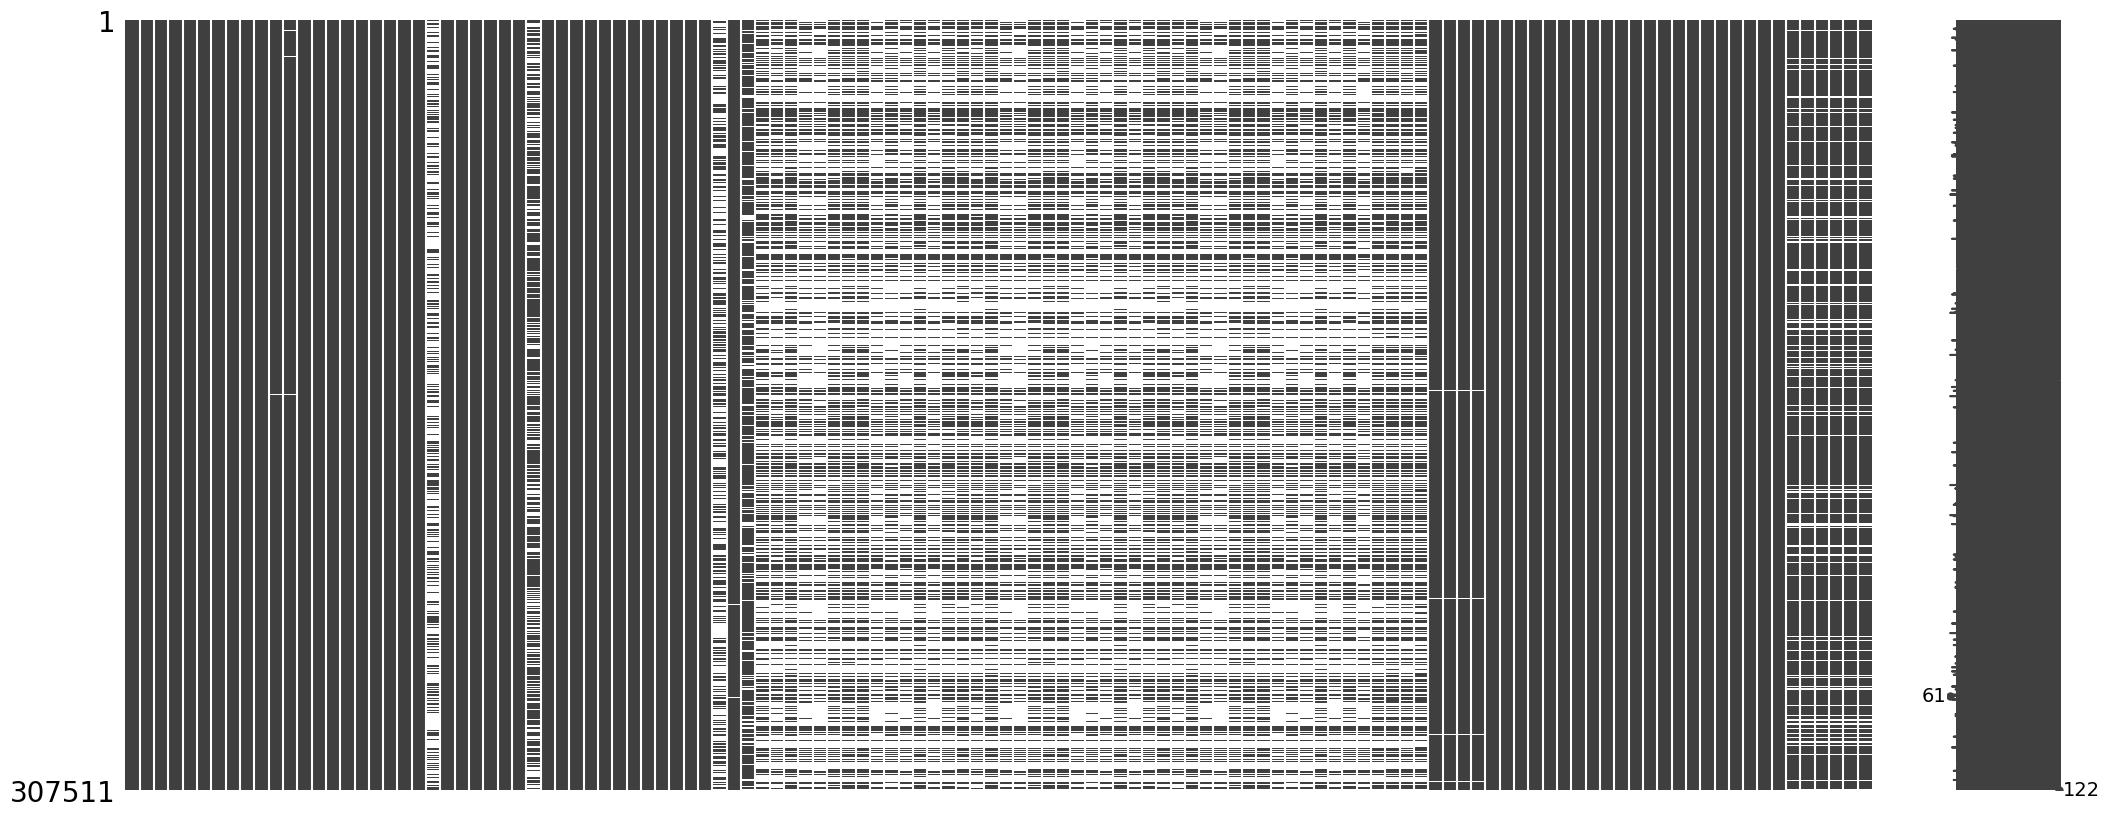

In [18]:
# Visualizing missing data
msno.matrix(df)

In [19]:
def boolswap(series):
    # Swaps 0 and 1 in a series
    series = series.replace({
        0: 1,
        1: 0
    })
    return series

In [20]:
# 0 = actual negatives, 1 = actual positives
df['TARGET'] = boolswap(df['TARGET'])
df['TARGET'].value_counts()

1    282686
0     24825
Name: TARGET, dtype: int64

<Axes: >

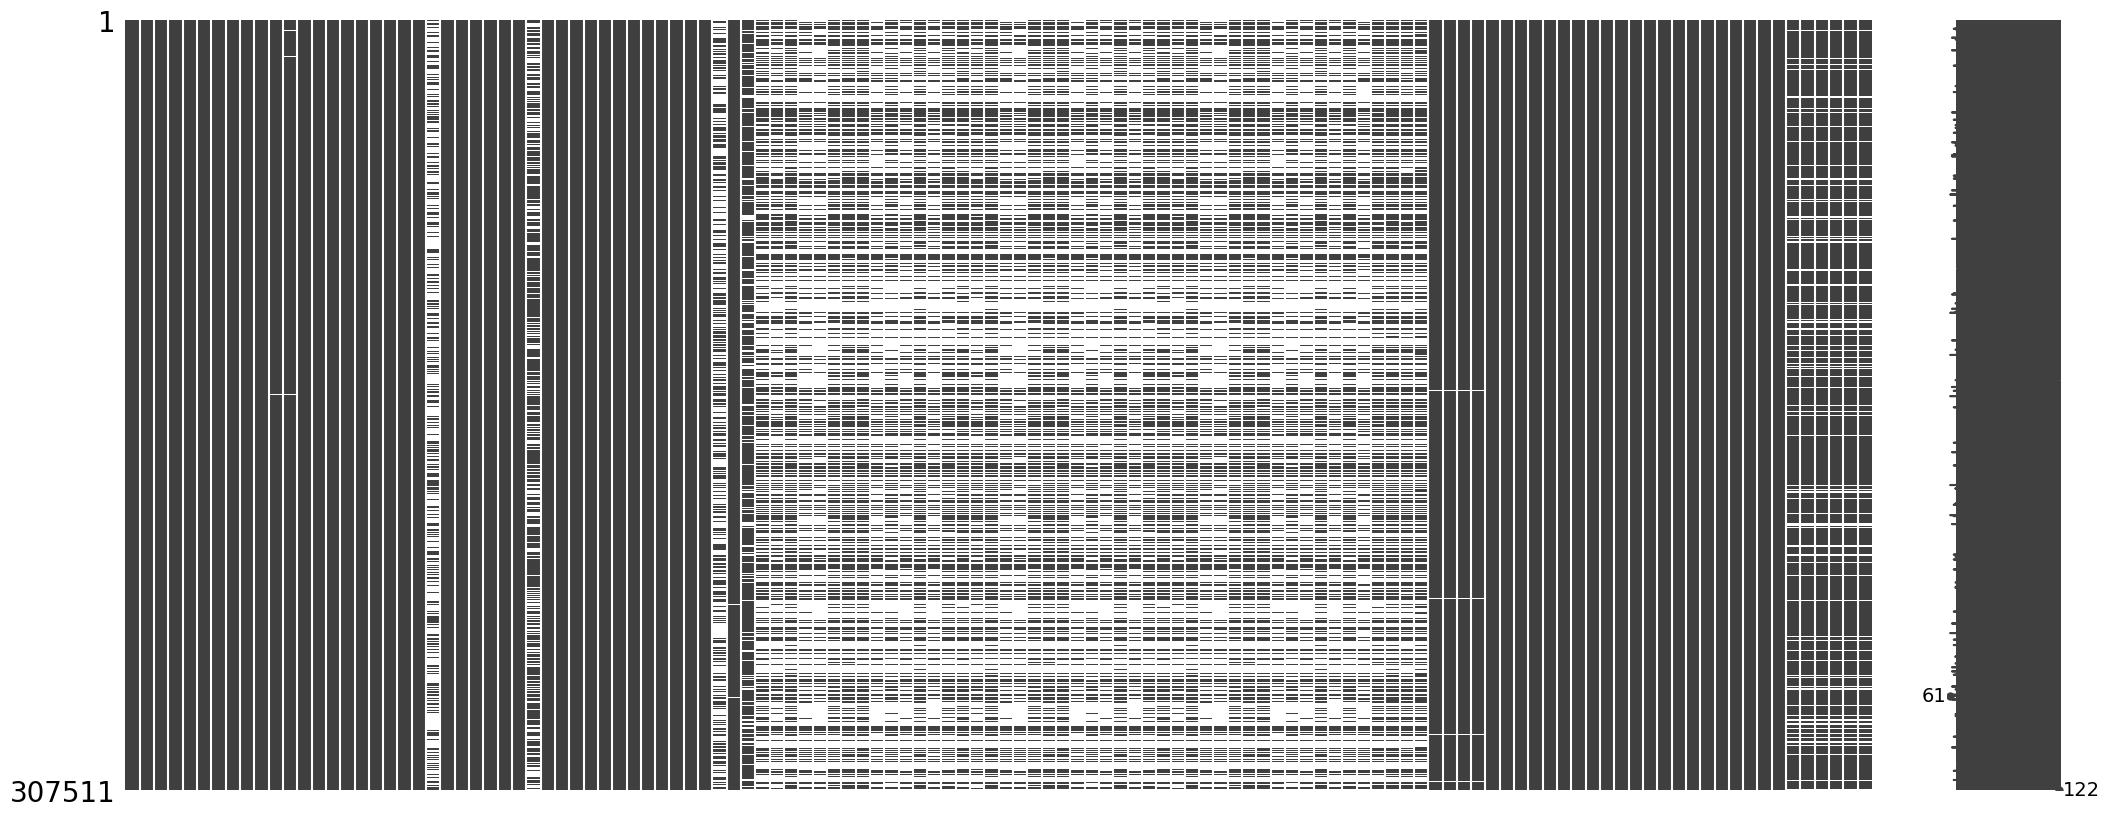

In [21]:
# Dropping duplicates
df = df.drop_duplicates()
msno.matrix(df)

<Axes: >

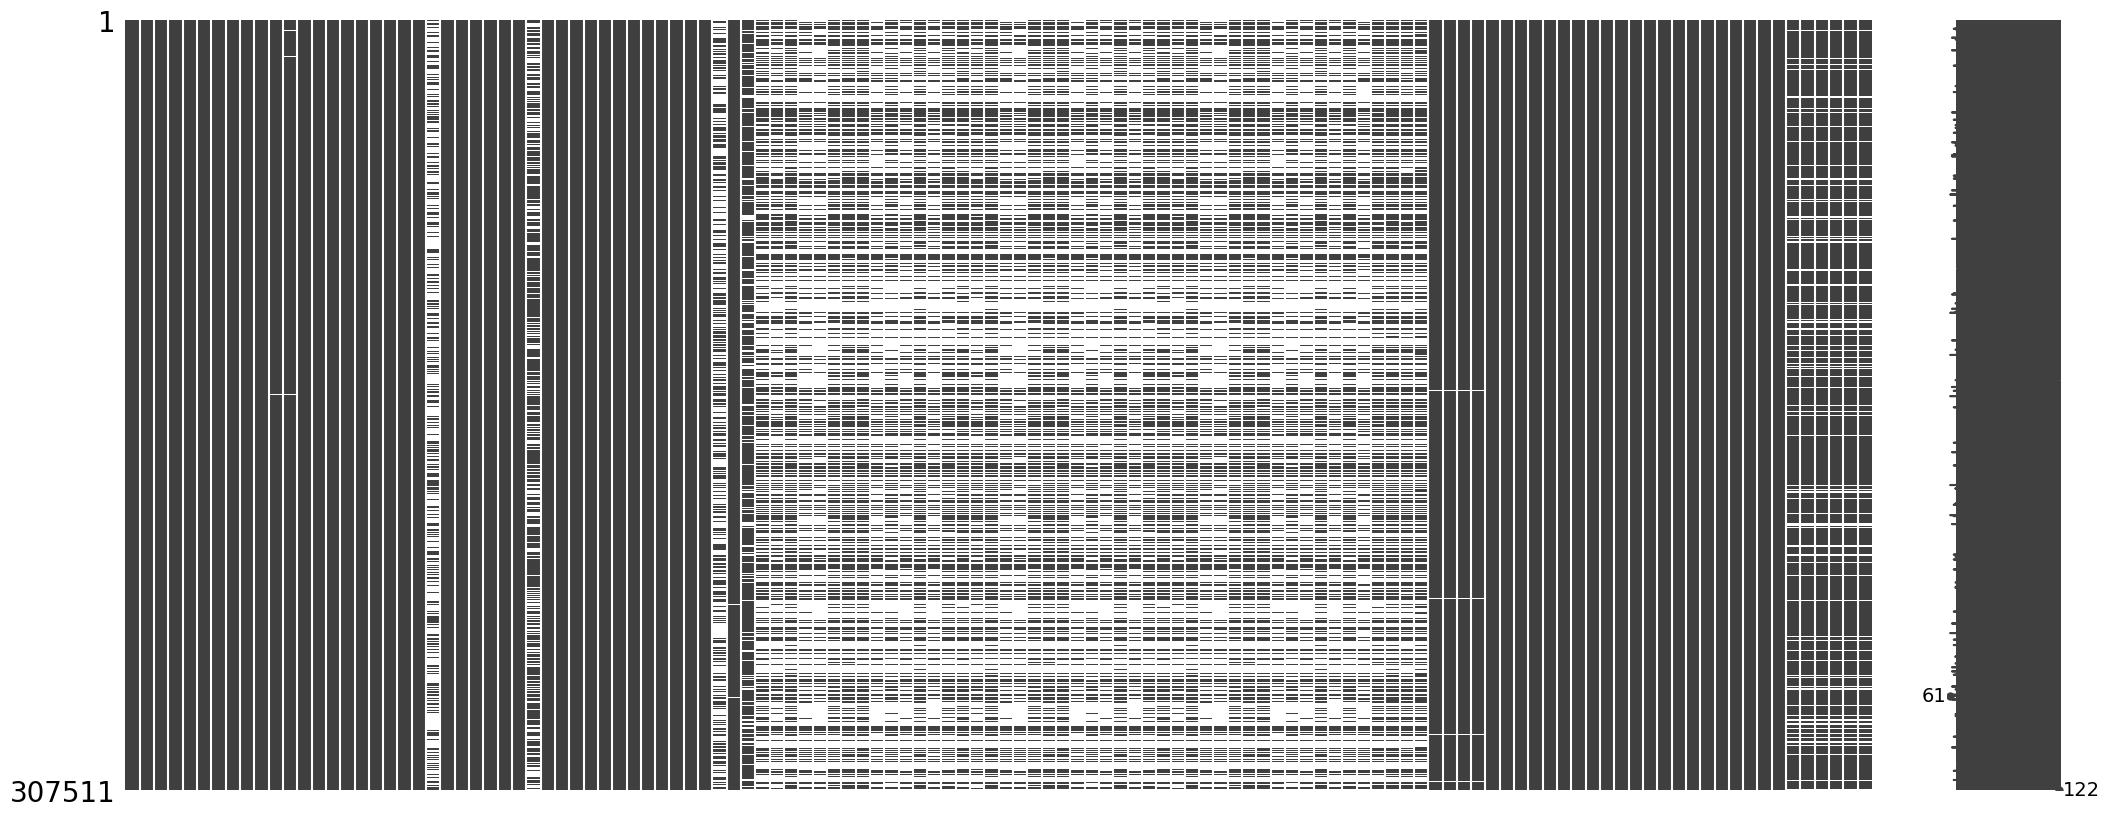

In [22]:
df = df.drop_duplicates(subset=['SK_ID_CURR'])
msno.matrix(df)

<Axes: >

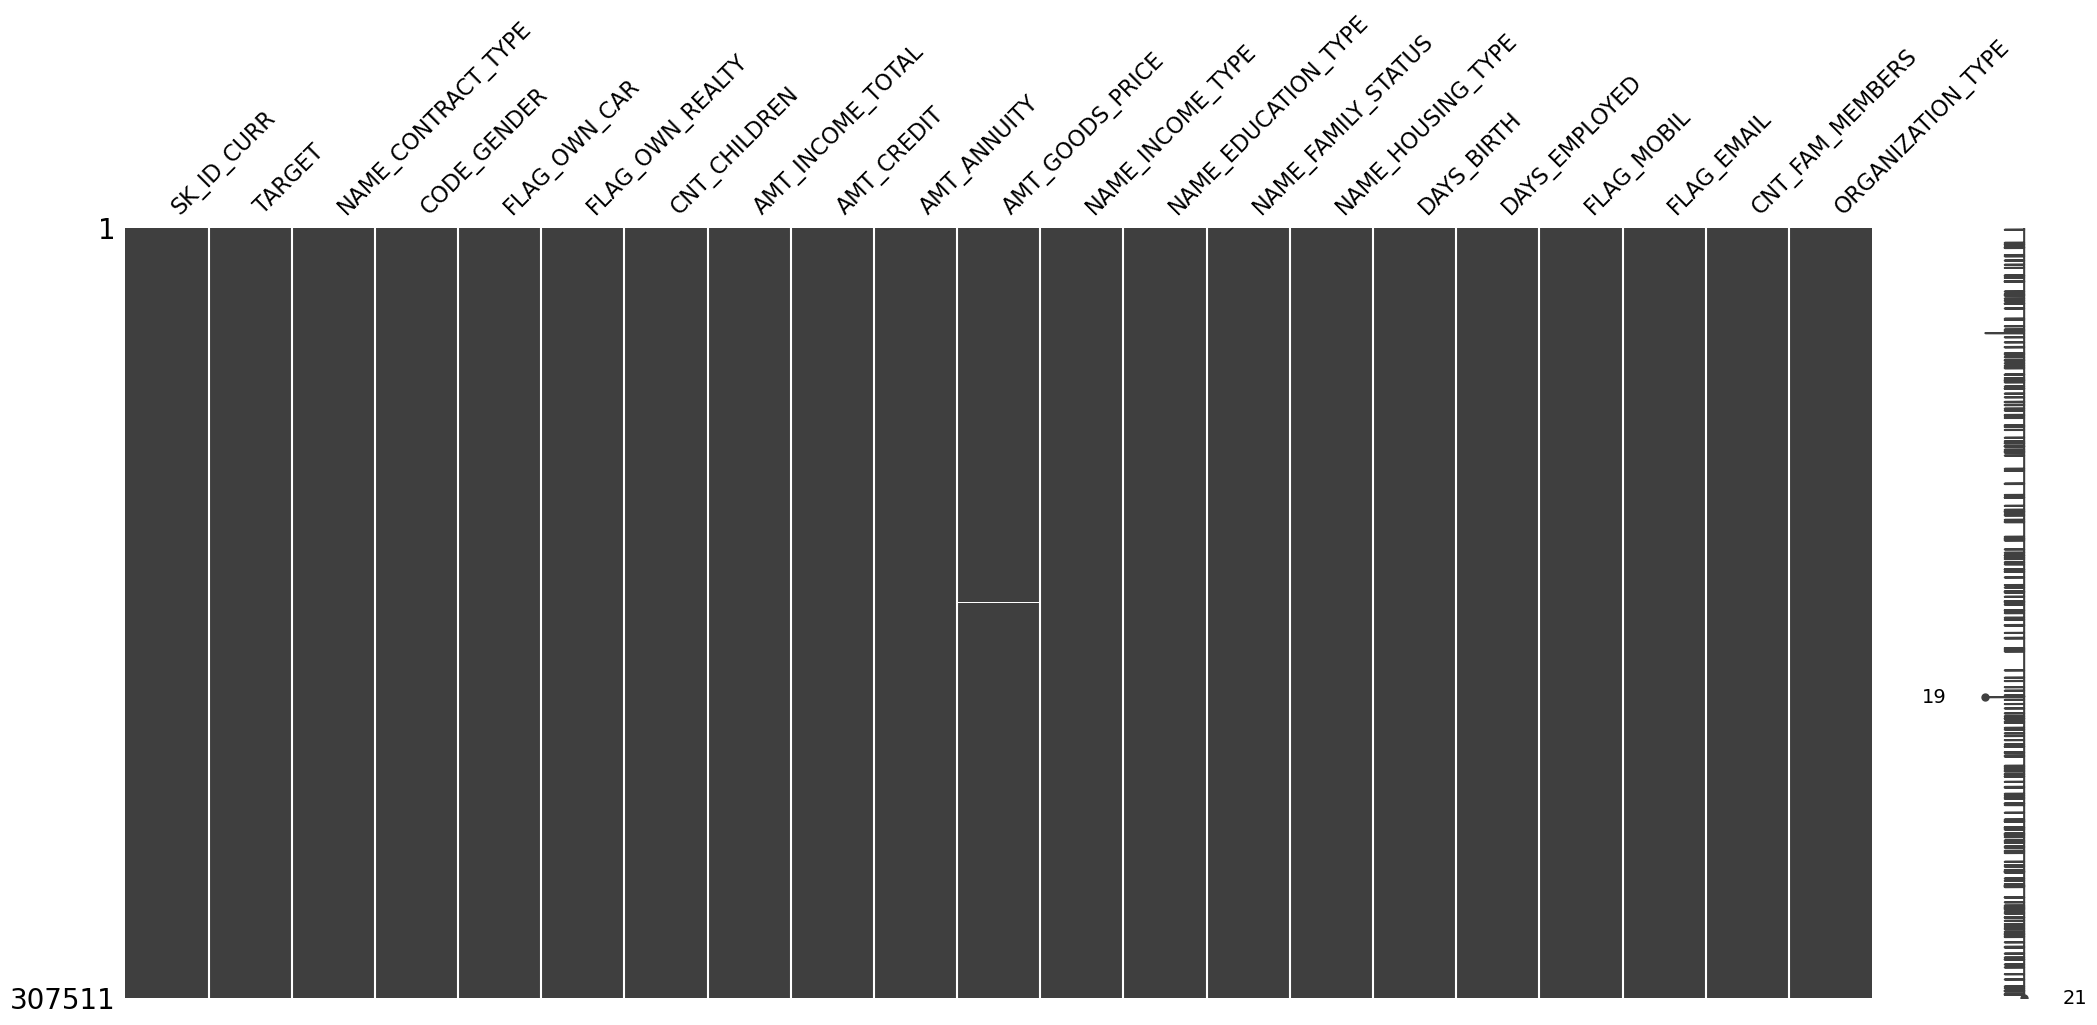

In [23]:
# Dropping non-essential columns or too empty columns
to_drop = [
    'NAME_TYPE_SUITE',
    'WEEKDAY_APPR_PROCESS_START',
    'HOUR_APPR_PROCESS_START',
    'OWN_CAR_AGE',
    'DAYS_REGISTRATION',
    'DAYS_ID_PUBLISH',
    'FLAG_EMP_PHONE',
    'FLAG_WORK_PHONE',
    'FLAG_CONT_MOBILE',
    'FLAG_PHONE',
    'REG_REGION_NOT_LIVE_REGION',
    'REG_REGION_NOT_WORK_REGION',
    'LIVE_REGION_NOT_WORK_REGION',
    'REG_CITY_NOT_LIVE_CITY',
    'REG_CITY_NOT_WORK_CITY',
    'LIVE_CITY_NOT_WORK_CITY',
    'OBS_30_CNT_SOCIAL_CIRCLE',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE',
    'DAYS_LAST_PHONE_CHANGE',
    'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'REGION_RATING_CLIENT',
    'REGION_RATING_CLIENT_W_CITY',
    'REGION_POPULATION_RELATIVE',
    'FLAG_DOCUMENT_2',
    'FLAG_DOCUMENT_3',
    'FLAG_DOCUMENT_4',
    'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6',
    'FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8',
    'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10',
    'FLAG_DOCUMENT_11',
    'FLAG_DOCUMENT_12',
    'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14',
    'FLAG_DOCUMENT_15',
    'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18',
    'FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20',
    'FLAG_DOCUMENT_21',
    'APARTMENTS_AVG',
    'BASEMENTAREA_AVG',
    'YEARS_BEGINEXPLUATATION_AVG',
    'YEARS_BUILD_AVG',
    'COMMONAREA_AVG',
    'ELEVATORS_AVG',
    'ENTRANCES_AVG',
    'FLOORSMAX_AVG',
    'FLOORSMIN_AVG',
    'LANDAREA_AVG',
    'LIVINGAPARTMENTS_AVG',
    'LIVINGAREA_AVG',
    'NONLIVINGAPARTMENTS_AVG',
    'NONLIVINGAREA_AVG',
    'APARTMENTS_MODE',
    'BASEMENTAREA_MODE',
    'YEARS_BEGINEXPLUATATION_MODE',
    'YEARS_BUILD_MODE',
    'COMMONAREA_MODE',
    'ELEVATORS_MODE',
    'ENTRANCES_MODE',
    'FLOORSMAX_MODE',
    'FLOORSMIN_MODE',
    'LANDAREA_MODE',
    'LIVINGAPARTMENTS_MODE',
    'LIVINGAREA_MODE',
    'NONLIVINGAPARTMENTS_MODE',
    'NONLIVINGAREA_MODE',
    'APARTMENTS_MEDI',
    'BASEMENTAREA_MEDI',
    'YEARS_BEGINEXPLUATATION_MEDI',
    'YEARS_BUILD_MEDI',
    'COMMONAREA_MEDI',
    'ELEVATORS_MEDI',
    'ENTRANCES_MEDI',
    'FLOORSMAX_MEDI',
    'FLOORSMIN_MEDI',
    'LANDAREA_MEDI',
    'LIVINGAPARTMENTS_MEDI',
    'LIVINGAREA_MEDI',
    'NONLIVINGAPARTMENTS_MEDI',
    'NONLIVINGAREA_MEDI',
    'TOTALAREA_MODE',
    'FONDKAPREMONT_MODE',
    'WALLSMATERIAL_MODE',
    'HOUSETYPE_MODE',
    'EMERGENCYSTATE_MODE',
    'OCCUPATION_TYPE'
]

df = df.drop(to_drop, axis=1)
msno.matrix(df)

<Axes: >

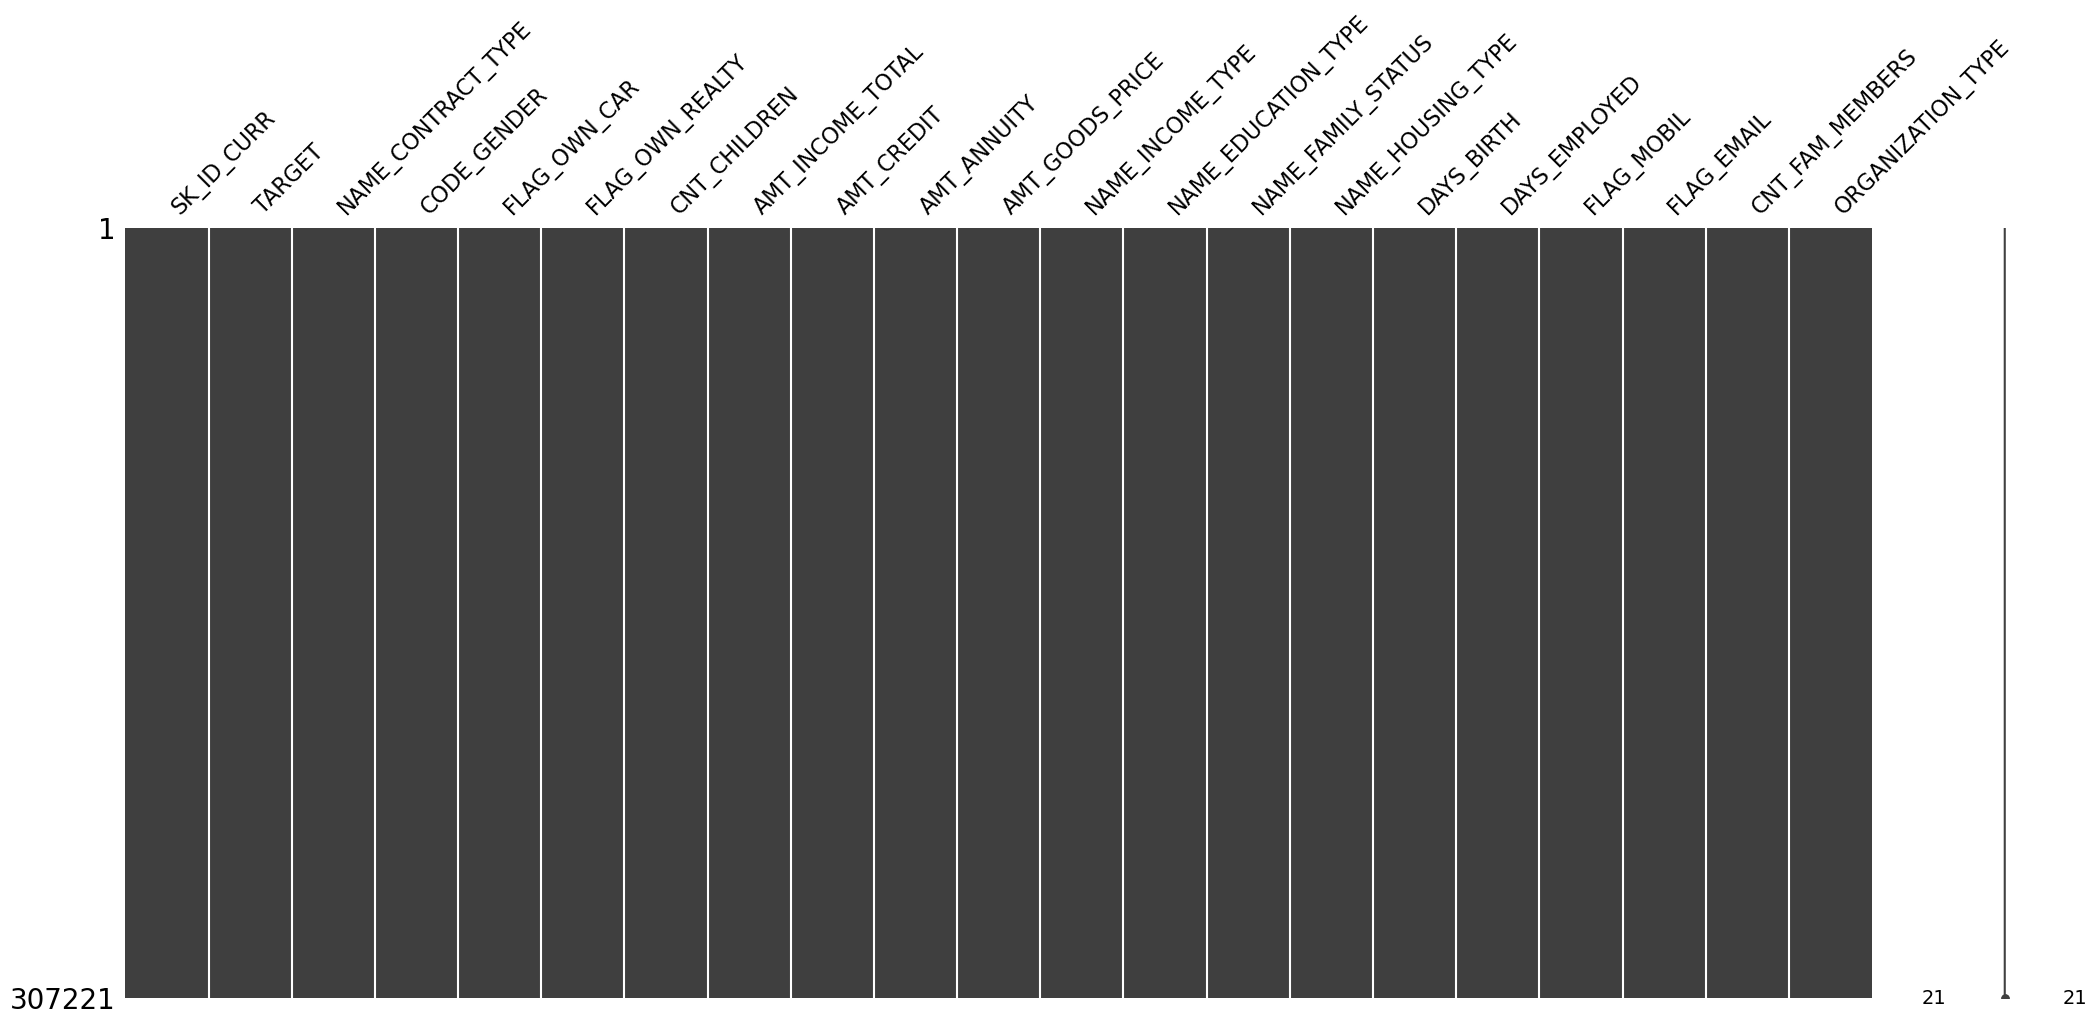

In [24]:
# Dropping the few lines still missing information
ind = df.loc[df['AMT_ANNUITY'].isna()].index
df = df.drop(ind, axis=0)

ind2 = df.loc[df['CNT_FAM_MEMBERS'].isna()].index
df = df.drop(ind2, axis=0)

ind3 = df.loc[df['AMT_GOODS_PRICE'].isna()].index
df = df.drop(ind3, axis=0)

msno.matrix(df)

In [25]:
# Feature engineering inspired by others on the Kaggle page
df['INCOME_CREDIT_RATE'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['ANNUITY_INCOME_RATE'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
df

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       0         Cash loans           M            N   
1           100003       1         Cash loans           F            N   
2           100004       1    Revolving loans           M            Y   
3           100006       1         Cash loans           F            N   
4           100007       1         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       1         Cash loans           M            N   
307507      456252       1         Cash loans           F            N   
307508      456253       1         Cash loans           F            N   
307509      456254       0         Cash loans           F            N   
307510      456255       1         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  ...  NAME_HOUSING_TYPE DAYS_BIRTH DAYS_EMPLOYED  \
0           24700.5  ...  House / apartment      -9461          -637   
1           35698.5  ...  House / apartment     -16765         -1188   
2            6750.0  ...  House / apartment     -19046          -225   
3           29686.5  ...  House / apartment     -19005         -3039   
4           21865.5  ...  House / apartment     -19932         -3038   
...             ...  ...                ...        ...           ...   
307506      27558.0  ...       With parents      -9327          -236   
307507      12001.5  ...  House / apartment     -20775        365243   
307508      29979.0  ...  House / apartment     -14966         -7921   
307509      20205.0  ...  House / apartment     -11961         -4786   
307510      49117.5  ...  House / apartment     -16856         -1262   

       FLAG_MOBIL FLAG_EMAIL  CNT_FAM_MEMBERS       ORGANIZATION_TYPE  \
0               1          0              1.0  Business Entity Type 3   
1               1          0              2.0                  School   
2               1          0              1.0              Government   
3               1          0              2.0  Business Entity Type 3   
4               1          0              1.0                Religion   
...           ...        ...              ...                     ...   
307506          1          0              1.0                Services   
307507          1          0              1.0                     XNA   
307508          1          1              1.0                  School   
307509          1          0              2.0  Business Entity Type 1   
307510          1          0              2.0  Business Entity Type 3   

        INCOME_CREDIT_RATE  ANNUITY_INCOME_RATE  PAYMENT_RATE  
0                 0.498036             0.121978      0.060749  
1                 0.208736             0.132217      0.027598  
2                 0.500000             0.100000      0.050000  
3                 0.431748             0.219900      0.094941  
4                 0.236842             0.179963      0.042623  
...                    ...                  ...           ...  
307506            0.618375             0.174971      0.108198  
307507            0.2671

## Treating outliers

In [26]:
df['CODE_GENDER'].value_counts()

F      202251
M      104966
XNA         4
Name: CODE_GENDER, dtype: int64

In [27]:
df = df[df['CODE_GENDER']!="XNA"]
df['CODE_GENDER'].value_counts()

F    202251
M    104966
Name: CODE_GENDER, dtype: int64

In [28]:
df['CNT_CHILDREN'].value_counts()

0     215180
1      61050
2      26723
3       3711
4        427
5         84
6         21
7          7
14         3
8          2
9          2
12         2
10         2
19         2
11         1
Name: CNT_CHILDREN, dtype: int64

In [29]:
df = df[df['CNT_CHILDREN']<7]
df['CNT_CHILDREN'].value_counts()

0    215180
1     61050
2     26723
3      3711
4       427
5        84
6        21
Name: CNT_CHILDREN, dtype: int64

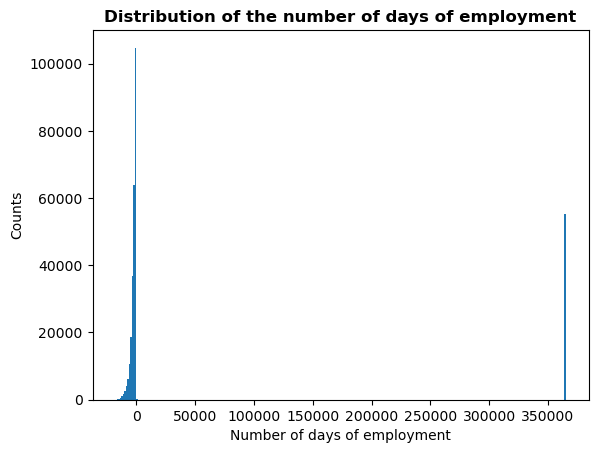

In [30]:
plt.hist(df['DAYS_EMPLOYED'], bins=300)
plt.ylabel('Counts')
plt.xlabel('Number of days of employment')
plt.title('Distribution of the number of days of employment', fontsize=12, fontweight='bold')
plt.show()

In [31]:
doe_max = df['DAYS_EMPLOYED'].max()
doe_max

365243

In [32]:
df.loc[df['DAYS_EMPLOYED']==doe_max]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
8           100011       1         Cash loans           F            N   
11          100015       1         Cash loans           F            N   
23          100027       1         Cash loans           F            N   
38          100045       1         Cash loans           F            N   
43          100050       1         Cash loans           F            N   
...            ...     ...                ...         ...          ...   
307469      456209       1         Cash loans           F            N   
307483      456227       1         Cash loans           F            N   
307487      456231       1         Cash loans           M            N   
307505      456249       1         Cash loans           F            N   
307507      456252       1         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
8                    Y             0        112500.000   1019610.0   
11                   Y             0         38419.155    148365.0   
23                   Y             0         83250.000    239850.0   
38                   Y             0         99000.000    247275.0   
43                   Y             0        108000.000    746280.0   
...                ...           ...               ...         ...   
307469               Y             0        202500.000    703728.0   
307483               Y             0         99000.000    247275.0   
307487               Y             0        117000.000   1071909.0   
307505               Y             0        112500.000    225000.0   
307507               Y             0         72000.000    269550.0   

        AMT_ANNUITY  ...  NAME_HOUSING_TYPE DAYS_BIRTH DAYS_EMPLOYED  \
8           33826.5  ...  House / apartment     -20099        365243   
11          10678.5  ...  House / apartment     -20417        365243   
23          23850.0  ...  House / apartment     -24827        365243   
38          17338.5  ...  House / apartment     -23920        365243   
43          42970.5  ...  House / apartment     -23548        365243   
...             ...  ...                ...        ...           ...   
307469      29943.0  ...  House / apartment     -22414        365243   
307483      16479.0  ...  House / apartment     -24911        365243   
307487      31473.0  ...  House / apartment     -23125        365243   
307505      22050.0  ...  House / apartment     -24384        365243   
307507      12001.5  ...  House / apartment     -20775        365243   

       FLAG_MOBIL FLAG_EMAIL  CNT_FAM_MEMBERS  ORGANIZATION_TYPE  \
8               1          0              2.0                XNA   
11              1          0              2.0                XNA   
23              1          0              2.0                XNA   
38              1          0              2.0                XNA   
43              1          0              1.0                XNA   
...           ...        ...              ...                ...   
307469          1          0              1.0                XNA   
307483          1          0              1.0                XNA   
307487          1          0              2.0                XNA   
307505          1          0              1.0                XNA   
307507          1          0              1.0                XNA   

        INCOME_CREDIT_RATE  ANNUITY_INCOME_RATE  PAYMENT_RATE  
8                 0.110336             0.300680      0.033176  
11                0.258950             0.277947      0.071975  
23                0.347092             0.286486      0.099437  
38                0.400364             0.175136      0.070118  
43                0.144718             0.397875      0.057580  
...                    ...                  ...           ...  
307469            0.287753             0.147867      0.042549  
307483            0.400364             0.166455      0.066642  
307487            0.

<Axes: >

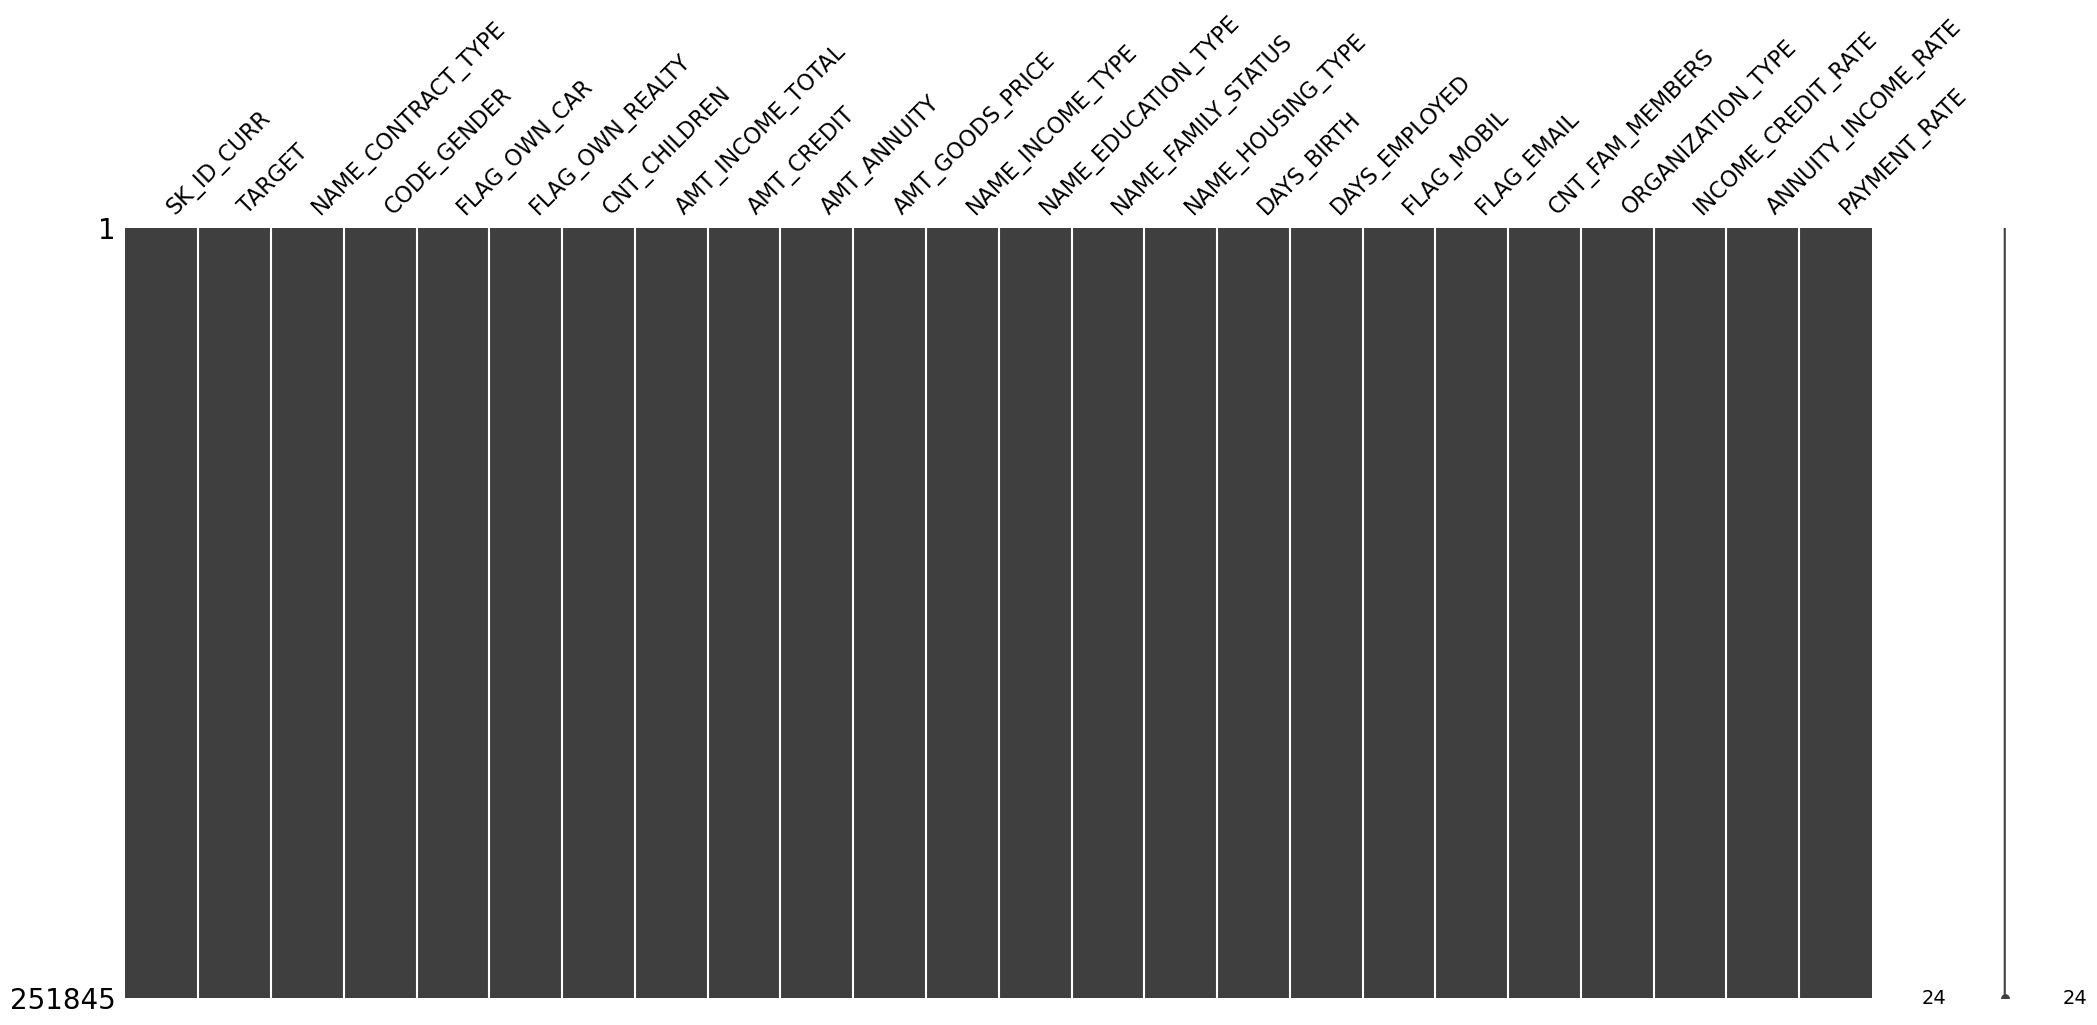

In [33]:
df = df[df['DAYS_EMPLOYED']<doe_max]
df['DAYS_EMPLOYED'] = - df['DAYS_EMPLOYED'] 
msno.matrix(df)

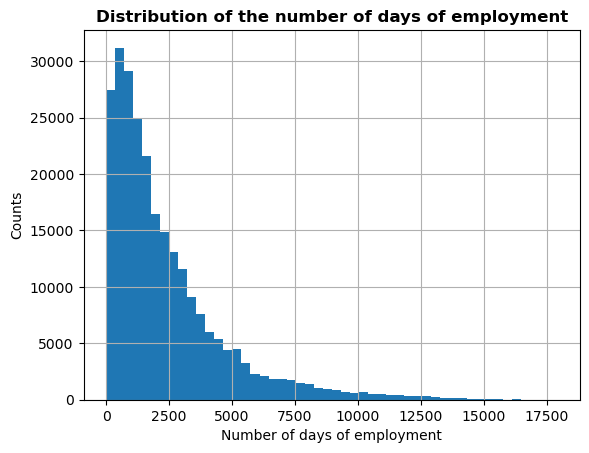

In [34]:
plt.hist(df['DAYS_EMPLOYED'], bins=50)
plt.ylabel('Counts')
plt.xlabel('Number of days of employment')
plt.title('Distribution of the number of days of employment', fontsize=12, fontweight='bold')
plt.grid()
plt.show()

In [35]:
def IQ_analysis(series):
    # Sets the outliers to NaN in a Series
    try:
        series.sort_values(ascending=True)
        # First quartile
        Q1 = series.quantile(0.25)
        # Third quartile
        Q3 = series.quantile(0.75)
        # Interquartile range
        IQ = Q3 - Q1
        # Lower bound
        lower = Q1 - 1.5*IQ
        # Upper bound
        upper = Q3 + 1.5*IQ
        # For each element in the Series
        for i in range(len(series)):
            # If value out of the bounds
            if series.iloc[i] > upper or series.iloc[i] < lower:
                # Setting to NaN
                series.iloc[i]=float('nan')
        return series
    except TypeError:
        return series

<Axes: >

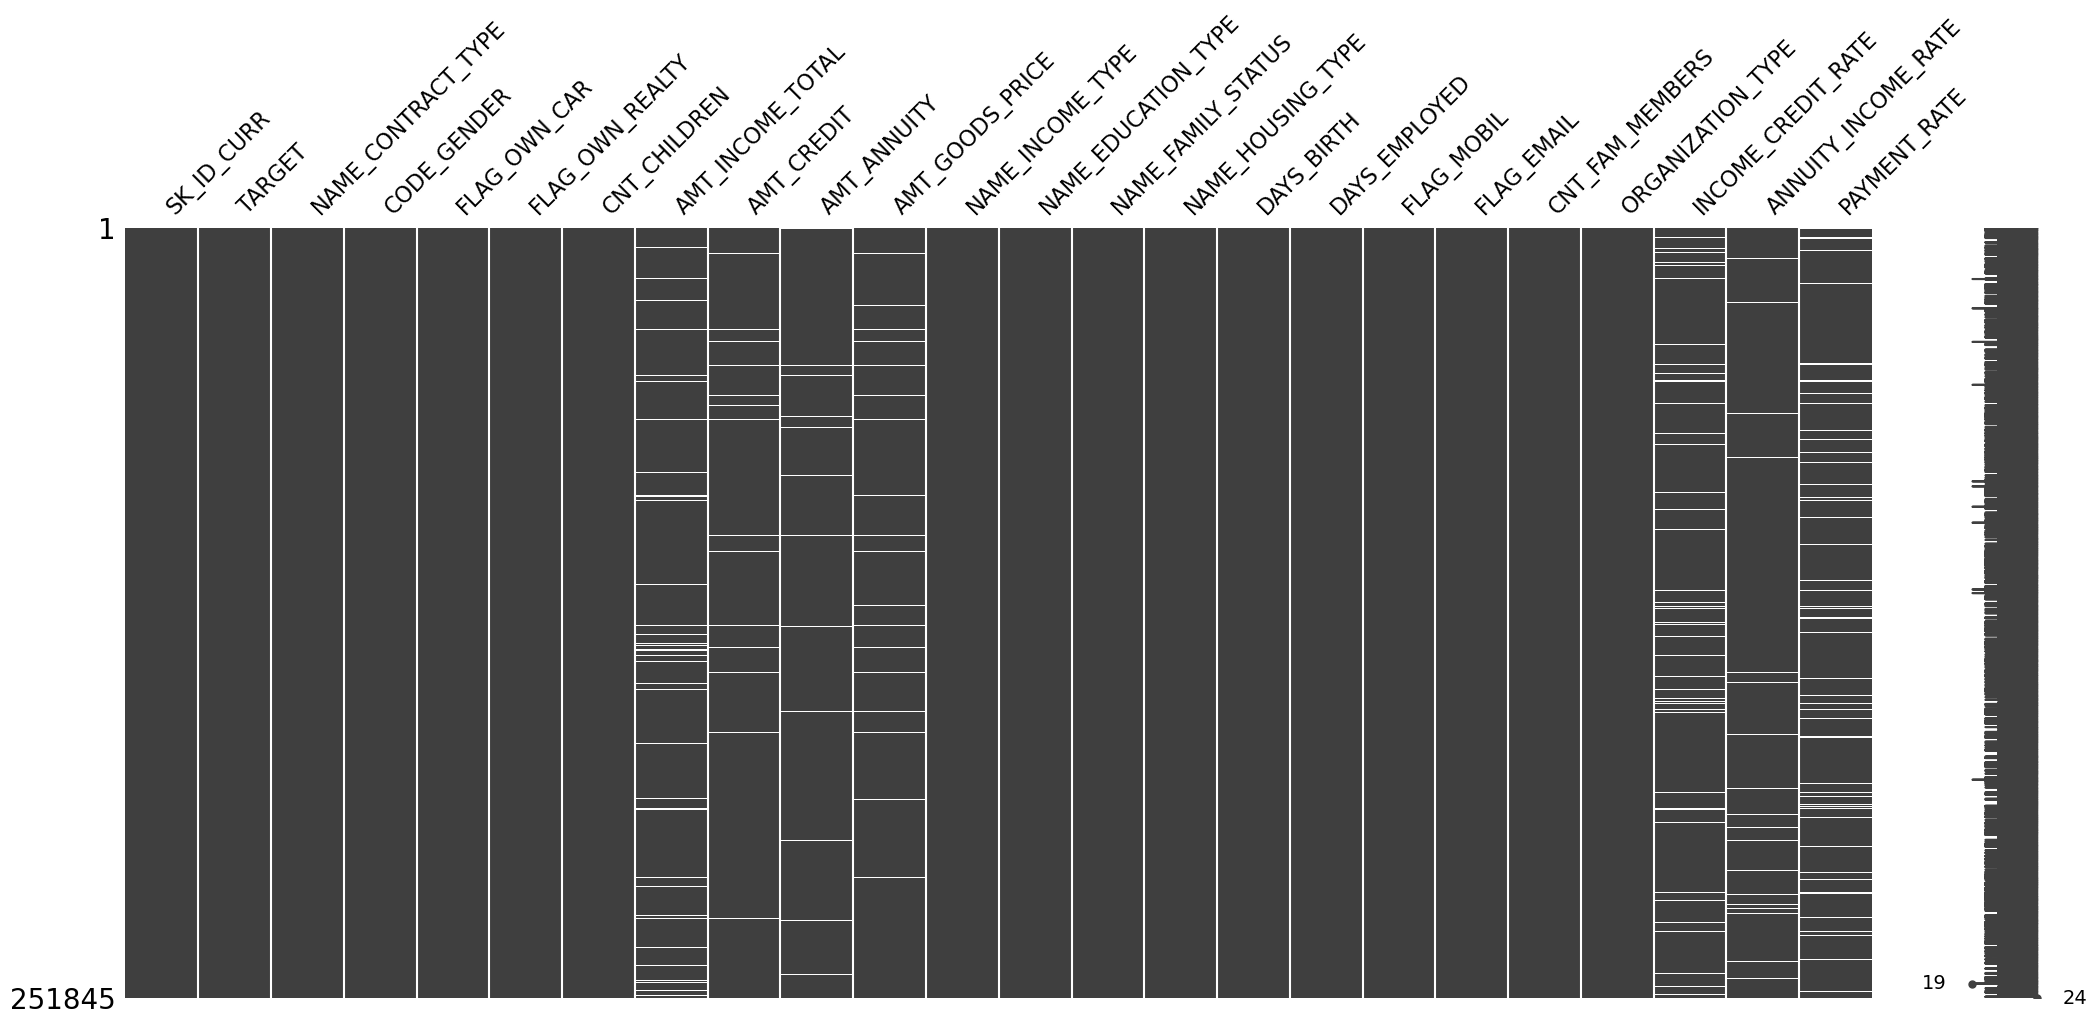

In [36]:
cont = [
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE',
    'INCOME_CREDIT_RATE',
    'ANNUITY_INCOME_RATE',
    'PAYMENT_RATE'    
]

for i in cont:
    df[i] = IQ_analysis(df[i])

msno.matrix(df)

<Axes: >

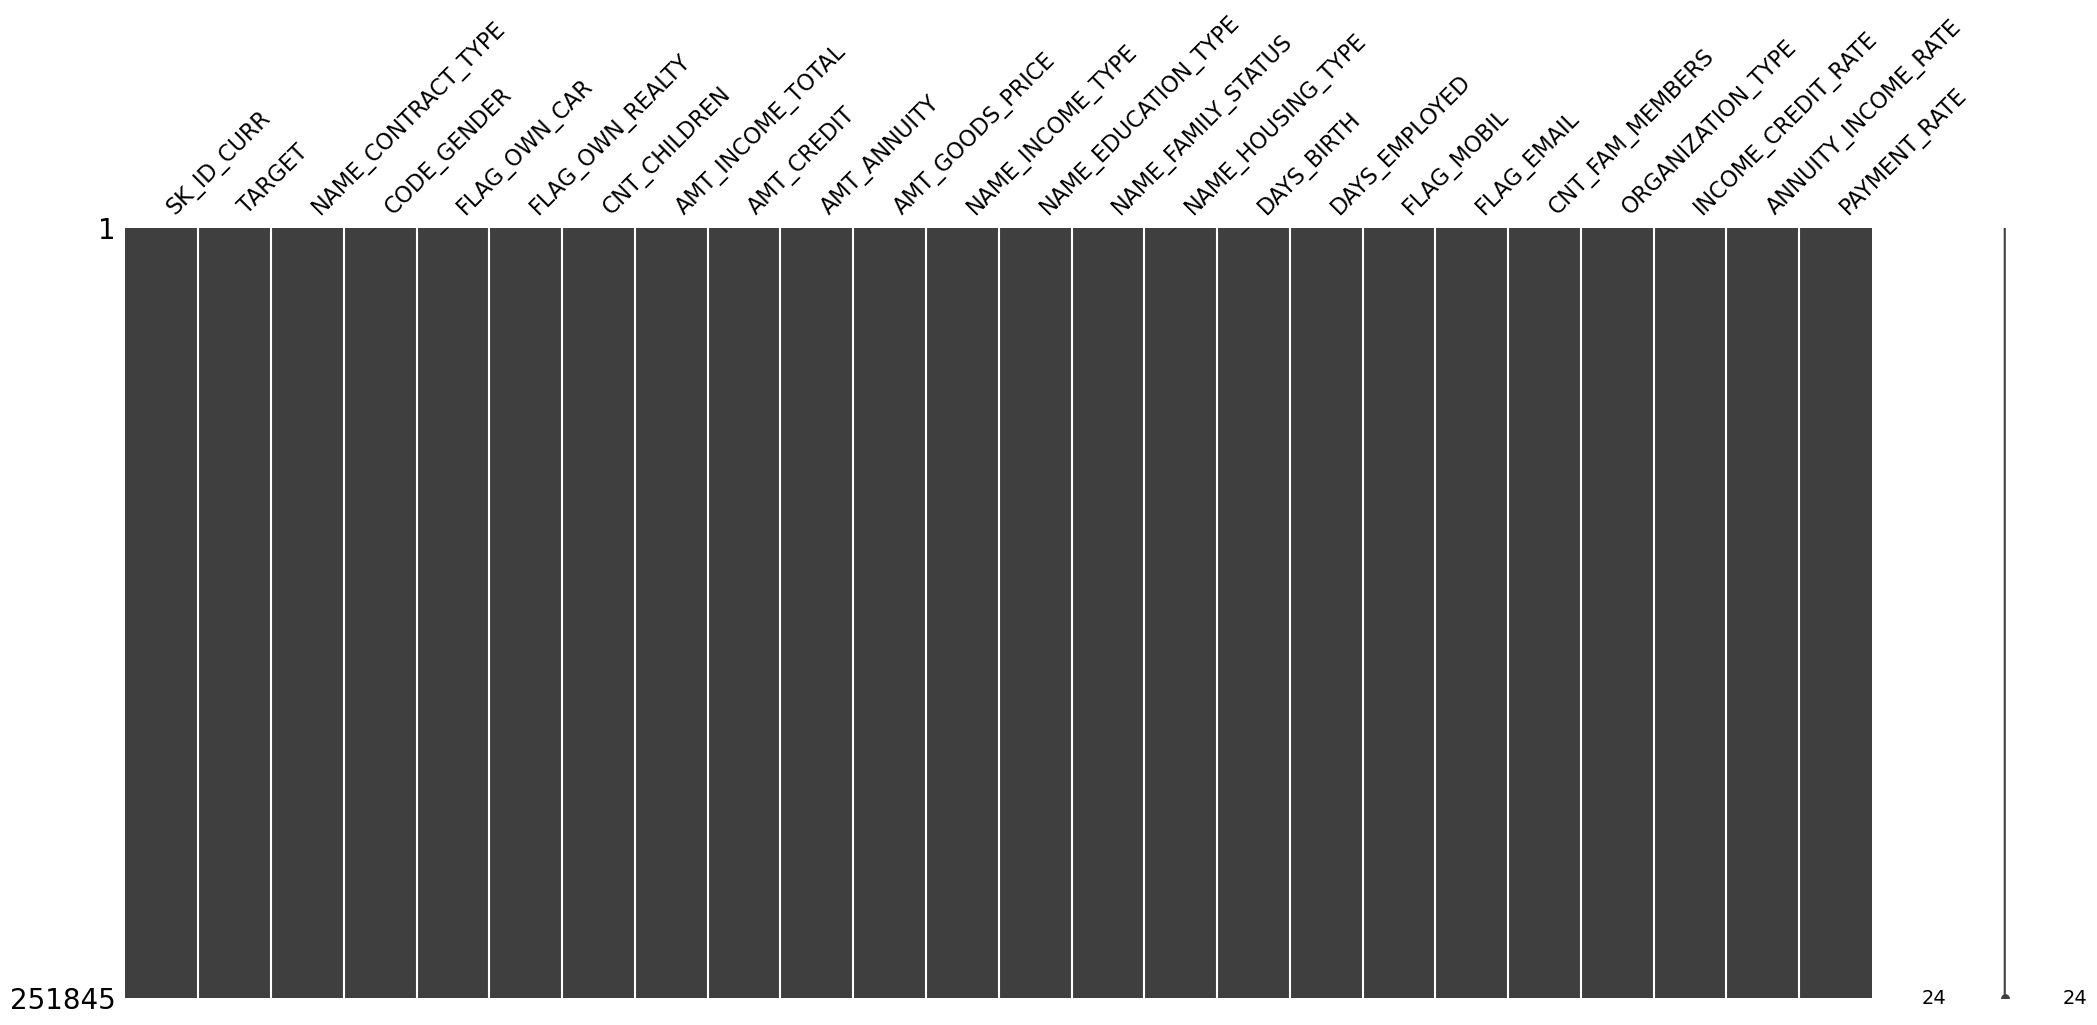

In [37]:
# Replacing outliers by mean value for continuous variables
imputer_mean = SimpleImputer(strategy='mean')
imputer_mean.fit(df[cont])
df[cont] = imputer_mean.transform(df[cont])
msno.matrix(df)

<Axes: >

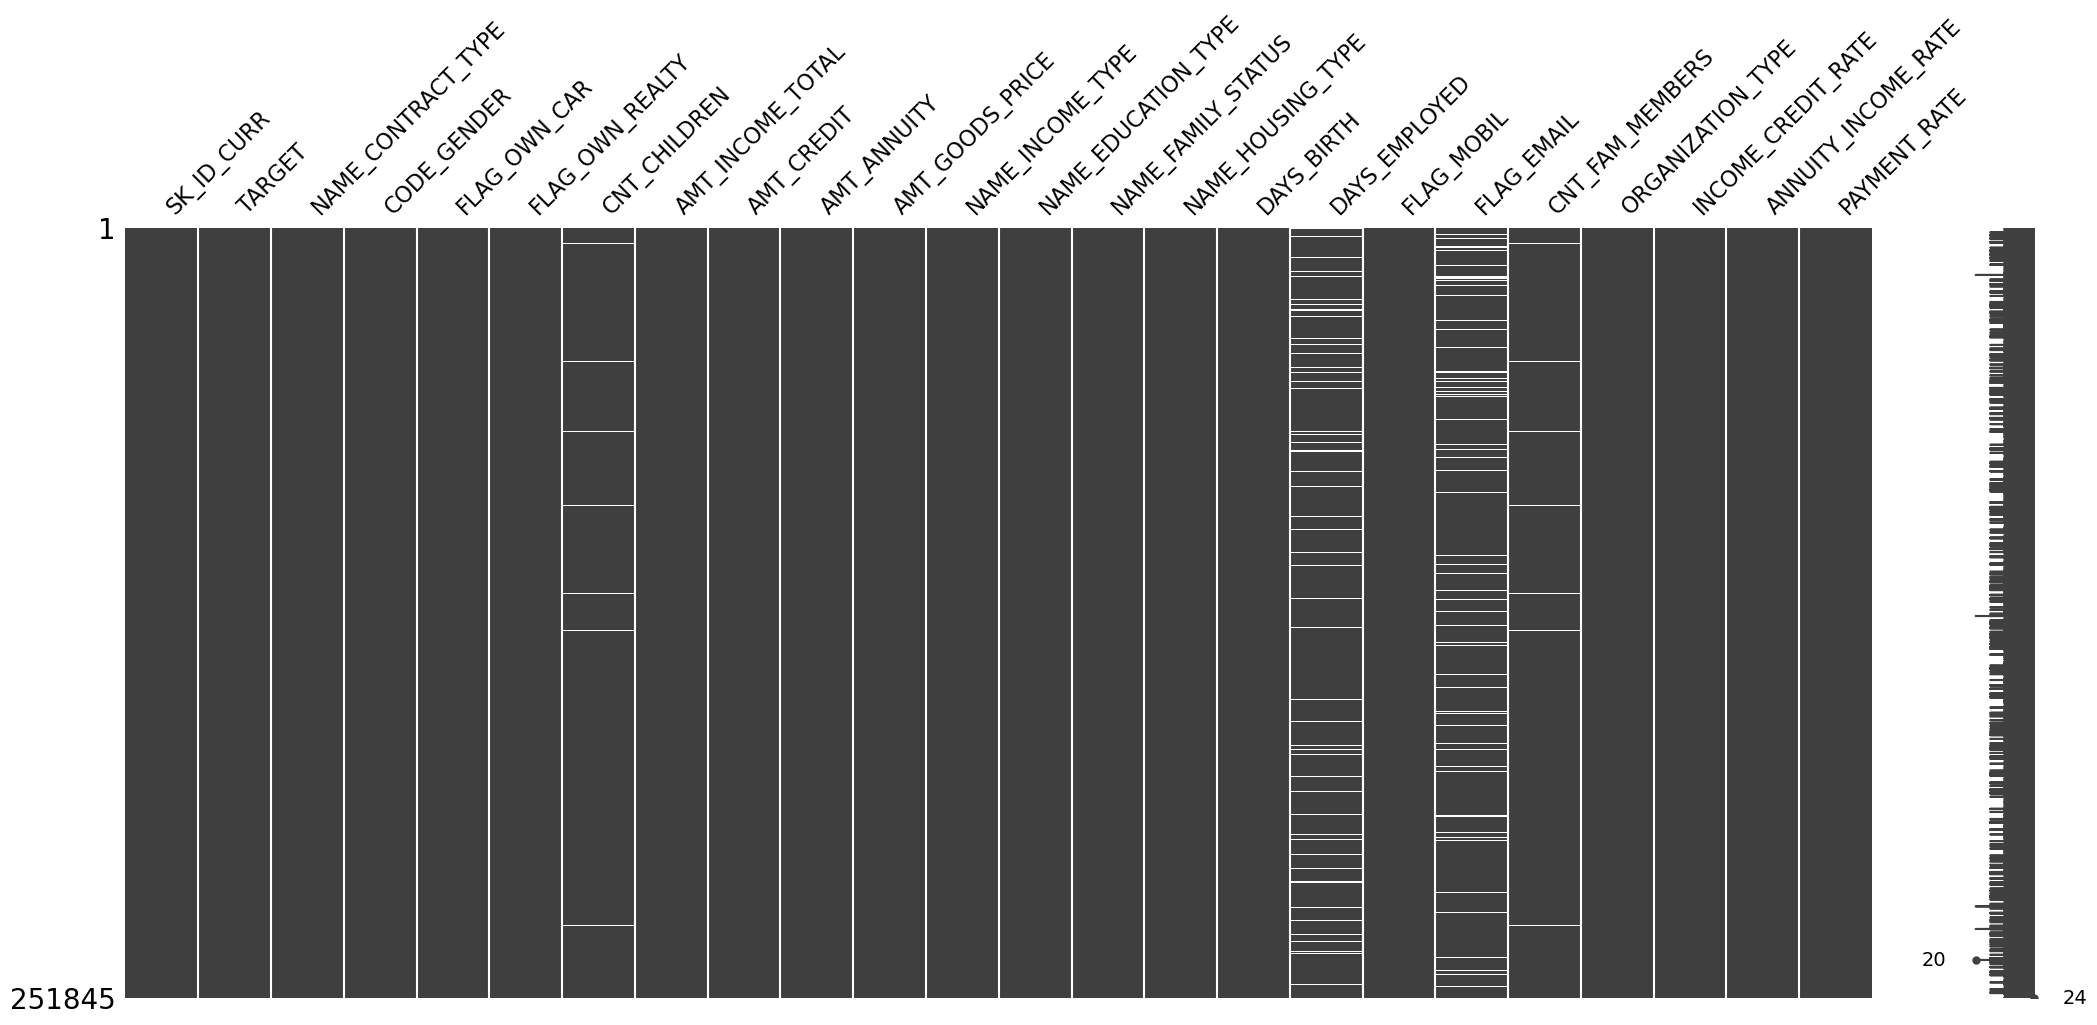

In [38]:
categ = [
    'CNT_CHILDREN',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'CNT_FAM_MEMBERS',
    'FLAG_MOBIL',
    'FLAG_EMAIL',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'ORGANIZATION_TYPE',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE'  
]

for i in categ:
    df[i] = IQ_analysis(df[i])

msno.matrix(df)

<Axes: >

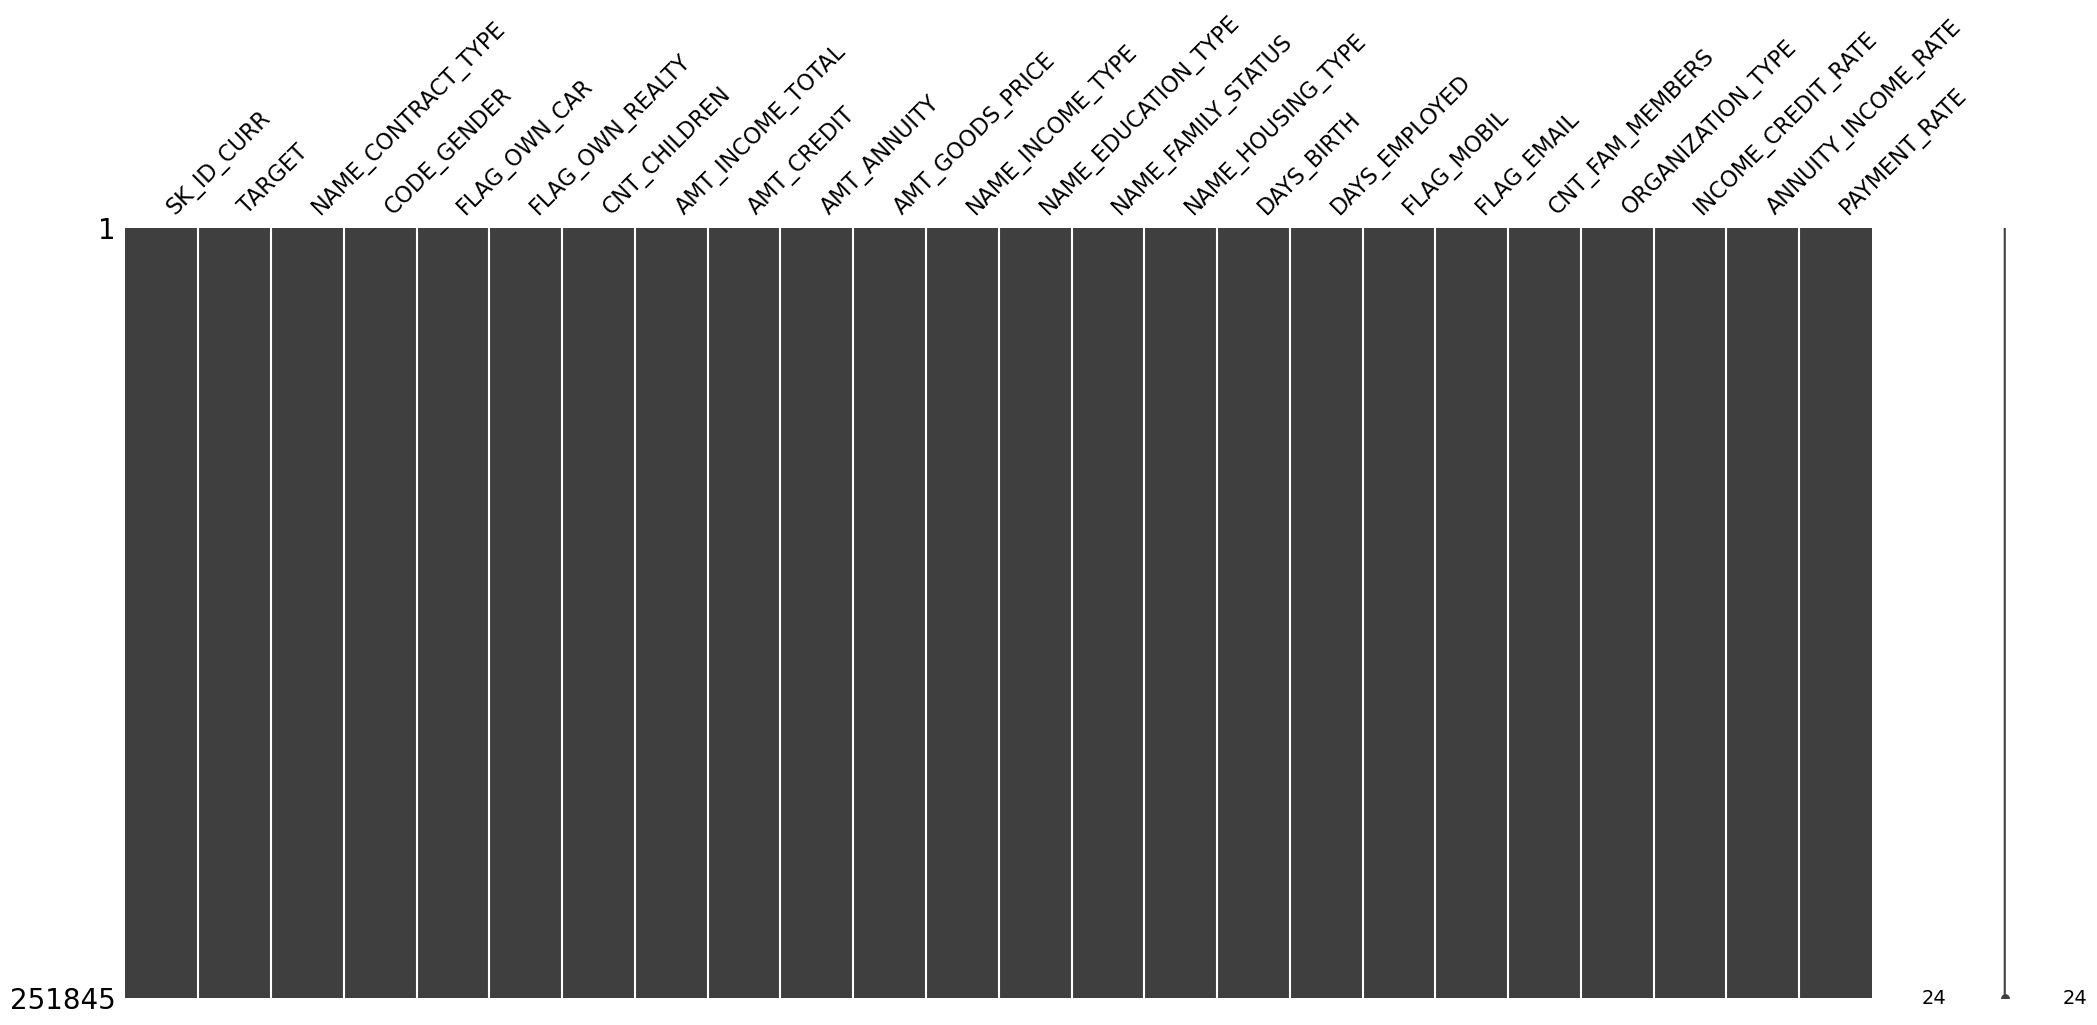

In [39]:
# Replacing outliers by most frequent value for discrete variables
imputer_mf = SimpleImputer(strategy='most_frequent')
imputer_mf.fit(df[categ])
df[categ] = imputer_mf.transform(df[categ])
msno.matrix(df)

In [40]:
# Saving imputers in a pickle
imputers_dict = {
    'imputer_mean': imputer_mean,
    'imputer_most_frequent': imputer_mf
}

# Save in pickle format
pickle.dump(imputers_dict, open('Pickles/imputers.pkl', 'wb'))

## Study of correlations to avoid data leakage

C:\Users\Paul\AppData\Local\Temp\ipykernel_10964\669049896.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

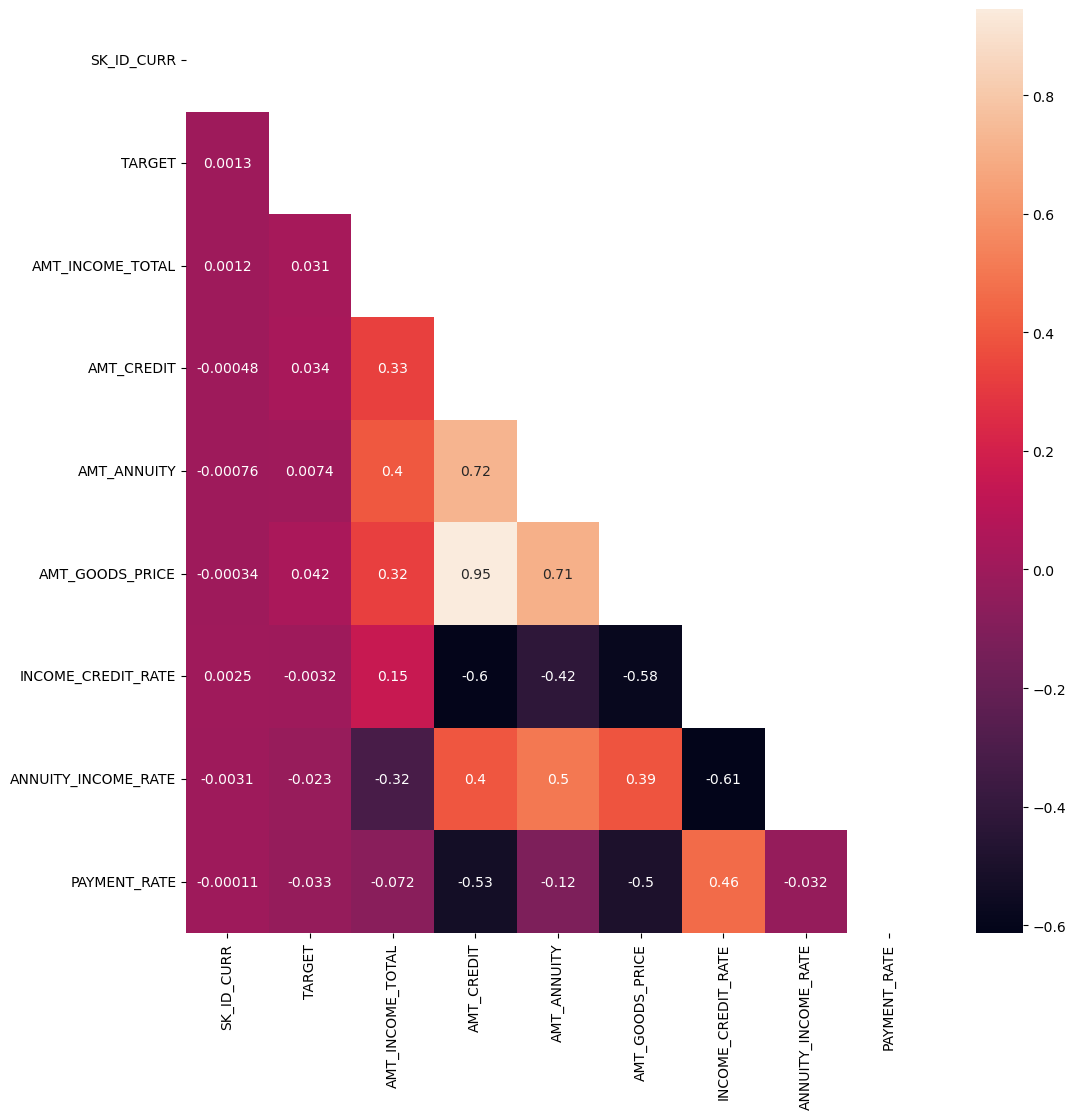

In [41]:
plt.figure(figsize=(12,12))
corr = df.corr()
mask = np.triu(corr)
sns.heatmap(corr, mask=mask, annot=True)

C:\Users\Paul\AppData\Local\Temp\ipykernel_10964\2116738357.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

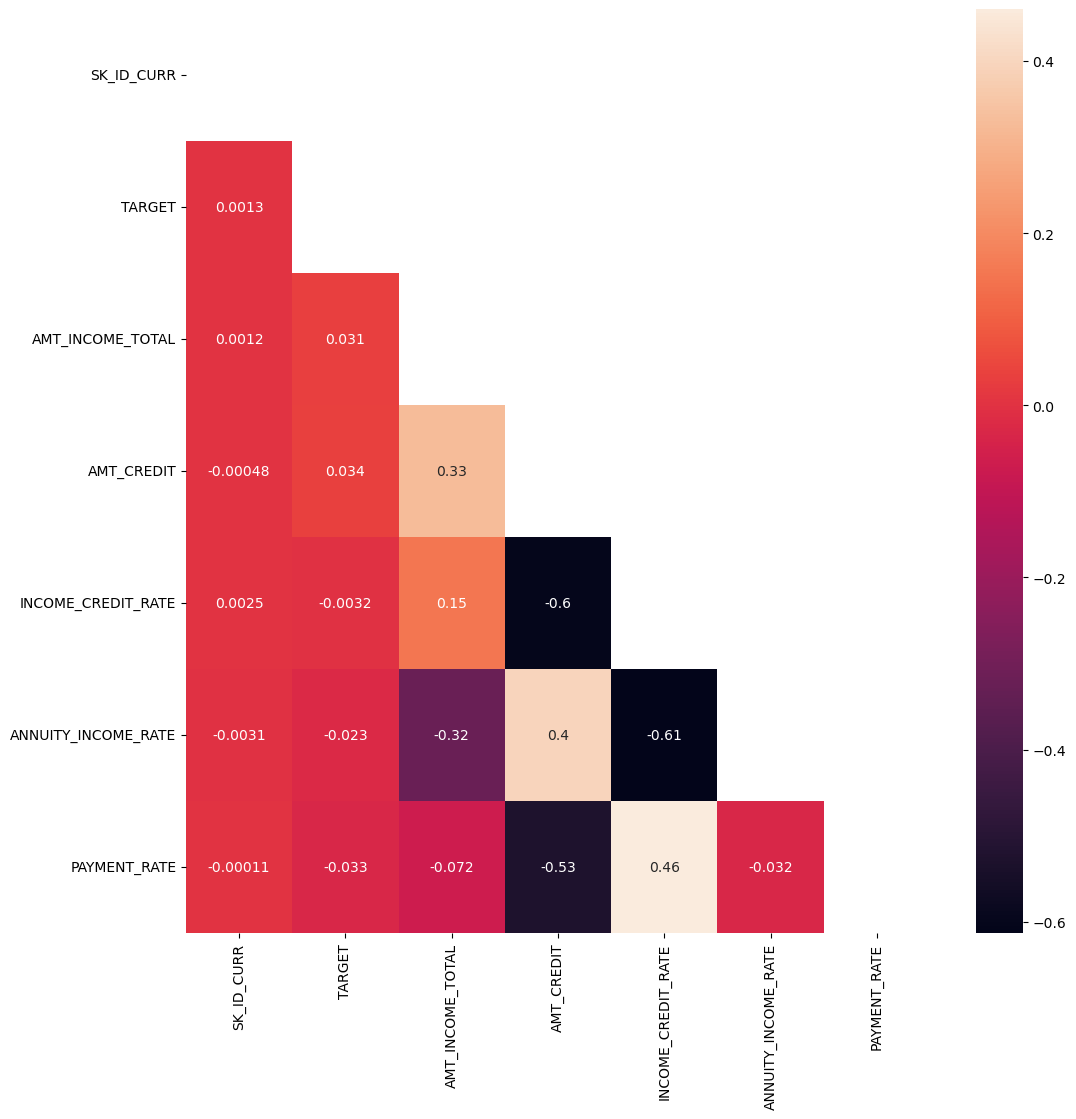

In [42]:
# Dropping variables that are too correlated
df = df.drop(['CNT_CHILDREN', 'AMT_ANNUITY', 'AMT_GOODS_PRICE'], axis=1)
plt.figure(figsize=(12,12))
corr = df.corr()
mask = np.triu(corr)
sns.heatmap(corr, mask=mask, annot=True)

In [43]:
df = df.set_index('SK_ID_CURR')
df

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002           0         Cash loans           M            N   
100003           1         Cash loans           F            N   
100004           1    Revolving loans           M            Y   
100006           1         Cash loans           F            N   
100007           1         Cash loans           M            N   
...            ...                ...         ...          ...   
456248           1         Cash loans           F            N   
456251           1         Cash loans           M            N   
456253           1         Cash loans           F            N   
456254           0         Cash loans           F            N   
456255           1         Cash loans           F            N   

           FLAG_OWN_REALTY  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                 
100002                   Y          202500.0    406597.5   
100003                   N          270000.0   1293502.5   
100004                   Y           67500.0    135000.0   
100006                   Y          135000.0    312682.5   
100007                   Y          121500.0    513000.0   
...                    ...               ...         ...   
456248                   Y          153000.0    331920.0   
456251                   N          157500.0    254700.0   
456253                   Y          153000.0    677664.0   
456254                   Y          171000.0    370107.0   
456255                   N          157500.0    675000.0   

                NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
SK_ID_CURR                                                        
100002                   Working  Secondary / secondary special   
100003             State servant               Higher education   
100004                   Working  Secondary / secondary special   
100006                   Working  Secondary / secondary special   
100007                   Working  Secondary / secondary special   
...                          ...                            ...   
456248                   Working  Secondary / secondary special   
456251                   Working  Secondary / secondary special   
456253                   Working               Higher education   
456254      Commercial associate  Secondary / secondary special   
456255      Commercial associate               Higher education   

              NAME_FAMILY_STATUS  NAME_HOUSING_TYPE DAYS_BIRTH DAYS_EMPLOYED  \
SK_ID_CURR                                                                     
100002      Single / not married  House / apartment      -9461         637.0   
100003                   Married  House / apartment     -16765        1188.0   
100004      Single / not married  House / apartment     -19046         225.0   
100006            Civil marriage  House / apartment     -19005        3039.0   
100007      Single / not married  House / apartment     -19932        3038.0   
...                          ...                ...        ...           ...   
456248                 Separated  House / apartment     -16705         200.0   
456251                 Separated       With parents      -9327         236.0   
456253                 Separated  House / apartment     -14966         200.0   
456254                   Married  House / apartment     -11961        4786.0   
456255                   Married  House / apartment     -16856        1262.0   

           FLAG_MOBIL FLAG_EMAIL CNT_FAM_MEMBERS       ORGANIZATION_TYPE  \
SK_ID_CURR                                                                 
100002            1.0        0.0             1.0  Business Entity Type 3   
100003            1.0        0.0             2.0                  School   
100004            1.0        0.0             1.0              Government   
100006            1.0        0.0             2.0  Business Entity Type 3   
100

In [44]:
df.to_csv(PATH+'cleaned_data.csv', index=True, index_label='SK_ID_CURR')

## Label encoding

In [45]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']

In [46]:
# Label encoding categorical features
cat_to_encode = [
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'ORGANIZATION_TYPE',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE'
]
cat_features_ind = []
for i in cat_to_encode:
    cat_features_ind.append(X.columns.tolist().index(i))

cat_features_ind

[2, 3, 0, 1, 8, 9, 15, 6, 7]

In [47]:
def label_enc(df, features_ind):
    # Training label encoders for categorical features, storing them in a dictionnary
    classes_names_dict = {} # Label map
    transformers_dict = {} # Label encoders
    for feature in features_ind:
        le = LabelEncoder()
        le.fit(df.iloc[:, [feature]].values.ravel())
        classes_names_dict[feature] = le.classes_
        df.iloc[:, [feature]] = le.transform(df.iloc[:, [feature]].values.ravel())
        transformers_dict[df.columns.tolist()[feature]] = le
    return df, classes_names_dict, transformers_dict

In [48]:
X, classes_names_dict, transformers_dict = label_enc(X, cat_features_ind)
# Storing features as encoded
features_dict = {
    'all_features': X.columns.tolist(),
    'continuous_features': cont,
    'categorical_features': categ,
    'categorical_features_to_encode': cat_to_encode
}

C:\Users\Paul\AppData\Local\Temp\ipykernel_10964\1457122039.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, [feature]] = le.transform(df.iloc[:, [feature]].values.ravel())
C:\Users\Paul\AppData\Local\Temp\ipykernel_10964\1457122039.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, [feature]] = le.transform(df.iloc[:, [feature]].values.ravel())
C:\Users\Paul\AppData\Local\Temp\ipykernel_10964\1457122039.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace 

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
# Creating training and test sets
data_splitted = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}

# Modeling

## DummyClassifier

Accuracy:  0.9129623379459588
AUROC:  0.5


C:\Users\Paul\anaconda3\lib\site-packages\mlflow\models\signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
C:\Users\Paul\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


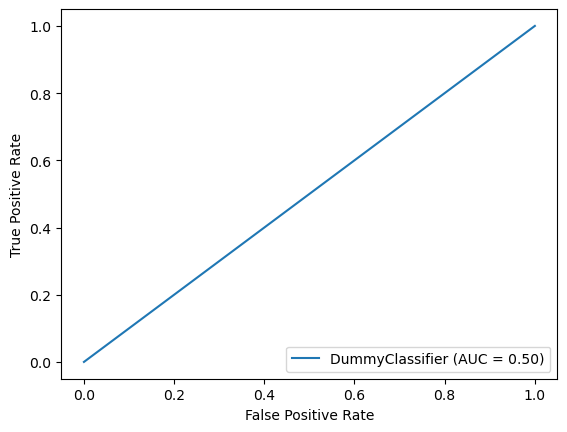

Run ID: b2a3c7e68d93469d90a9add6e3ab06dc


In [50]:
# Starting a MLflow run
with mlflow.start_run():
    # Calling the classifier
    dummy_clf = DummyClassifier(strategy='most_frequent')
    # Training
    dummy_clf.fit(X_train, y_train)
    # Predicting the targets
    dummy_predict = dummy_clf.predict(X_test.values)
    # Accuracy
    print("Accuracy: ", dummy_clf.score(dummy_predict, y_test))
    # AUC score
    print("AUROC: ", roc_auc_score(y_test, dummy_predict))
    # Logging parameters
    mlflow.log_param("strategy", "most_frequent")
    # Logging performances
    mlflow.log_metric("Accuracy", dummy_clf.score(dummy_predict, y_test))
    mlflow.log_metric("AUROC", roc_auc_score(y_test, dummy_predict))
    # Logging model
    signature = infer_signature(X_train, dummy_predict)
    mlflow.sklearn.log_model(dummy_clf, "DummyClassifier", signature=signature)
    
# Getting the ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, dummy_predict)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='DummyClassifier')
display.plot()
plt.show()
# Storing the model
print("Run ID: {}".format(mlflow.start_run().info.run_id))
mlflow.end_run()

In [51]:
def train_model(data, classifier, par_grid, scorer, scaling):
    """Optimizes a classifier with a GridSearch and cross validation. Trains and returns it
    data : dictionary containing the training and testing sets (input and target)
    classifier : model to train
    par_grid : grid of parameters to test in the GridSearch
    scorer : metric to evaluate the model performances
    scaling : True or False according if data has to be scaled before applying the model"""

    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']

    if scaling == True: # If the model is not tree-based, data is scaled
        # Solving data imbalance
        model = imbpipe(steps=[
            ('OverSampling', RandomOverSampler(random_state=42)),
            #('UnderSampling', RandomUnderSampler(random_state=42)),
            ('Scaling', StandardScaler()),
            ('classification', classifier)
        ])
    else : # If not tree-based, no scaling
        # Solving data imbalance
        model = imbpipe(steps=[
            ('OverSampling', RandomOverSampler(random_state=42)),
            #('UnderSampling', RandomUnderSampler(random_state=42)),
            #('Scaling', StandardScaler()),
            ('classification', classifier)
        ])
    # Looking for the best set of parameters according to the chosen metric
    model_trained = GridSearchCV(
        model,
        param_grid=par_grid,
        scoring=scorer,
        verbose=1,
        n_jobs=4
    )
    # Fitting trained model to data
    model_trained.fit(X_train, y_train)
    # Returning chosen parameters and performances
    print('Best hyperparams: ', model_trained.best_params_)
    print('Best mean score: ', model_trained.best_score_)
    print('std: ', model_trained.cv_results_['std_test_score'][model_trained.best_index_])
    # Returning model ready to be used
    return model_trained

## Logistic Regression

### Using AUC score

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best hyperparams:  {'classification__C': 0.002575, 'classification__max_iter': 20, 'classification__tol': 1e-15}
Best mean score:  0.6400399315791111
std:  0.0032564101182102137
AUROC:  0.5976422859644013


C:\Users\Paul\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Paul\anaconda3\lib\site-packages\mlflow\models\signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


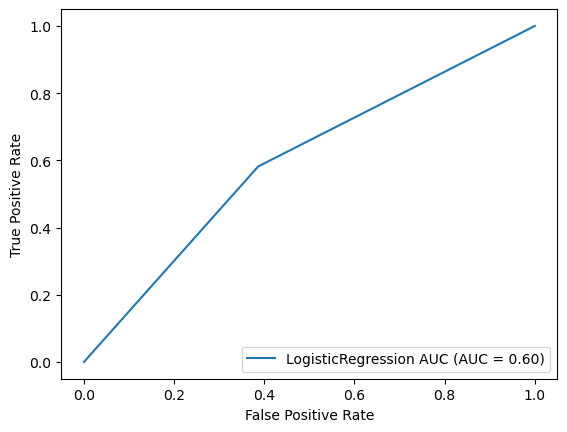

Run ID: 99f26cb8309b41ada1edfebcbd52bb8a


In [52]:
# Starting a MLflow run
with mlflow.start_run():
    # Calling the classifier
    LR_classifier = LogisticRegression()
    # Parameters grid
    par_grid = {
    'classification__tol': np.logspace(-15, 5, 10),
    'classification__C': np.linspace(0.0001, 0.01, 5),
    'classification__max_iter': [20, 30, 40]
    }
    # Grid search + cross validation + training
    LogReg = train_model(data_splitted, LR_classifier, par_grid, 'roc_auc', scaling=True)
    # Predicting the targets
    LR_predict = LogReg.predict(X_test.values)
    # AUC score
    print("AUROC: ", roc_auc_score(y_test, LR_predict))
    # Logging parameters
    mlflow.log_params(LogReg.best_params_)
    # Logging performances
    mlflow.log_metric("AUROC", roc_auc_score(y_test, LR_predict))
    mlflow.log_metric("Mean", LogReg.best_score_)
    mlflow.log_metric("Std", LogReg.cv_results_['std_test_score'][LogReg.best_index_])
    # Logging model
    signature = infer_signature(X_train, LR_predict)
    mlflow.sklearn.log_model(LogReg, "LogisticRegression AUC", signature=signature)
    
# Getting the ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, LR_predict)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='LogisticRegression AUC')
display.plot()
plt.show()
# Storing the model
print("Run ID: {}".format(mlflow.start_run().info.run_id))
mlflow.end_run()

### Using custom score

In [53]:
# Defining a score (f_beta) giving 10 times more importance to false positives than false negatives
beta = .1
scoring_fn = fbeta_score
custom_scoring_func = make_scorer(scoring_fn, beta=beta, greater_is_better=True)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best hyperparams:  {'classification__C': 0.01, 'classification__max_iter': 20, 'classification__tol': 215.44346900318823}
Best mean score:  0.9360960980892976
std:  0.0008190310335786754
AUROC:  0.5978433219456678


C:\Users\Paul\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Paul\anaconda3\lib\site-packages\mlflow\models\signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


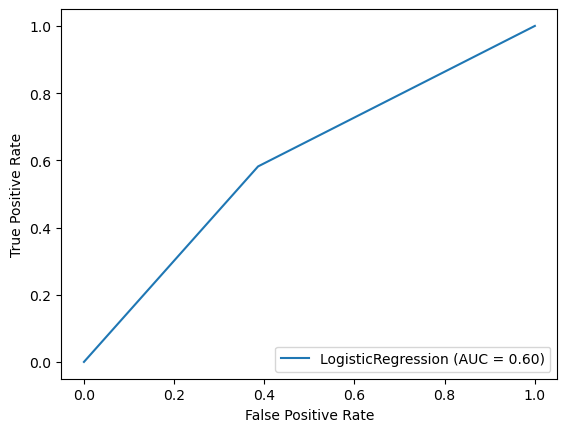

Run ID: 7984785d39b14d8c91c32f2974c3b27a


In [54]:
# Starting a MLflow run
with mlflow.start_run():
    # Calling the classifier
    LR_classifier = LogisticRegression()
    # Parameters grid
    par_grid = {
    'classification__tol': np.logspace(1, 5, 10),
    'classification__C': np.linspace(0.0001, 0.01, 5),
    'classification__max_iter': [20, 30, 40]
    }
    # Grid search + cross validation + training
    LogReg = train_model(data_splitted, LR_classifier, par_grid, custom_scoring_func, scaling=True)
    # Predicting the targets
    LR_predict = LogReg.predict(X_test.values)
    # AUC score
    print("AUROC: ", roc_auc_score(y_test, LR_predict))
    # Logging parameters
    mlflow.log_params(LogReg.best_params_)
    # Logging performances
    mlflow.log_metric("AUROC", roc_auc_score(y_test, LR_predict))
    mlflow.log_metric("Mean", LogReg.best_score_)
    mlflow.log_metric("Std", LogReg.cv_results_['std_test_score'][LogReg.best_index_])
    # Logging model
    signature = infer_signature(X_train, LR_predict)
    mlflow.sklearn.log_model(LogReg, "LogisticRegression", signature=signature)
    
# Getting the ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, LR_predict)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='LogisticRegression')
display.plot()
plt.show()
# Storing the model
print("Run ID: {}".format(mlflow.start_run().info.run_id))
mlflow.end_run()

## Random Forest

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best hyperparams:  {'classification__max_depth': 10, 'classification__max_features': 'sqrt', 'classification__min_samples_leaf': 5, 'classification__min_samples_split': 2}
Best mean score:  0.9402770276497131
std:  0.001092409372134419


C:\Users\Paul\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AUROC:  0.6209892705412507


C:\Users\Paul\anaconda3\lib\site-packages\mlflow\models\signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


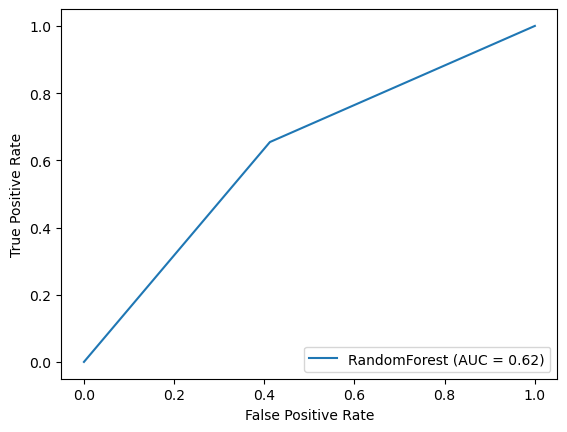

Run ID: a0d360fbbf2d4203a9928adb7b80e3d7


In [55]:
# Starting a MLflow run
with mlflow.start_run():
    # Calling the classifier
    RF_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    # Parameters grid
    par_grid = {
        'classification__max_depth': [10, 25, 50],
        'classification__min_samples_split': [2, 3, 5],
        'classification__max_features': ['sqrt', 'log2'],
        'classification__min_samples_leaf': [1, 3, 5]
    }
    # Grid search + cross validation + training
    RandFor = train_model(data_splitted, RF_classifier, par_grid, custom_scoring_func, scaling=False)
    # Predicting the targets
    RF_predict = RandFor.predict(X_test.values)
    # AUC score
    print("AUROC: ", roc_auc_score(y_test, RF_predict))
    # Logging parameters
    mlflow.log_params(RandFor.best_params_)
    # Logging performances
    mlflow.log_metric("AUROC", roc_auc_score(y_test, RF_predict))
    mlflow.log_metric("Mean", RandFor.best_score_)
    mlflow.log_metric("Std", RandFor.cv_results_['std_test_score'][RandFor.best_index_])
    # Logging model
    signature = infer_signature(X_train, RF_predict)
    mlflow.sklearn.log_model(RandFor, "RandomForest", signature=signature)
    
# Getting the ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, RF_predict)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='RandomForest')
display.plot()
plt.show()
# Storing the model
print("Run ID: {}".format(mlflow.start_run().info.run_id))
mlflow.end_run()

## Choosing a threshold

In [56]:
# Getting the probabilities from Random Forest model
rf_pred_probas = RandFor.predict_proba(X_test.values)[:,1]
rf_pred_probas

C:\Users\Paul\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0.58300983, 0.57575364, 0.57139675, ..., 0.63676257, 0.66697754,
       0.66303901])

In [57]:
# Looking for the best threshold in the probability prediction
thresholds = np.linspace(0, 1, 100)
betas = [0.005, 0.01, .05, .1, .5, 1.]
scores_df = pd.DataFrame(columns=thresholds)
# For each value of beta
for b in betas:
    f_scores = []
    # Calculating the F-scores associated to each value of threshold
    for t in thresholds:
        y_pred_tmp = [1 if p > t else 0 for p in rf_pred_probas]
        f_score = fbeta_score(y_test, y_pred_tmp, beta=b)
        f_scores.append(f_score)
    scores_df = pd.concat([scores_df, pd.DataFrame([f_scores], columns=thresholds, index=[b])])
# Getting a dataframe containing all the F-scores values
scores_df = scores_df.transpose()

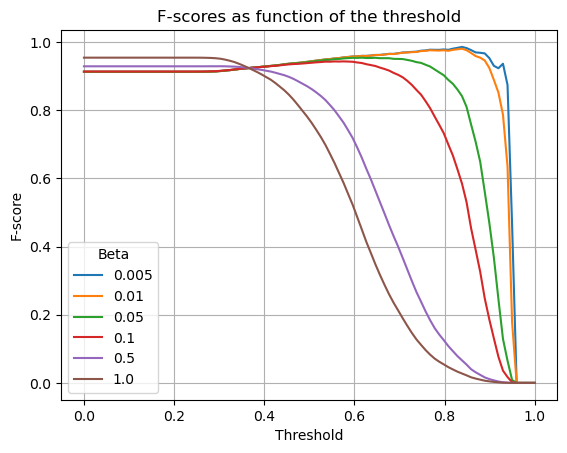

In [58]:
scores_df.plot(y=betas, use_index=True)
# Plotting the F-score for all these cases
plt.xlabel('Threshold')
plt.ylabel('F-score')
plt.title('F-scores as function of the threshold')
plt.legend(title='Beta')
plt.grid()

### beta = 0.05

In [59]:
selected_beta = .05
thresh = scores_df[selected_beta].idxmax()
thresh

0.6161616161616162

Threshold :  0.6161616161616162


<Axes: >

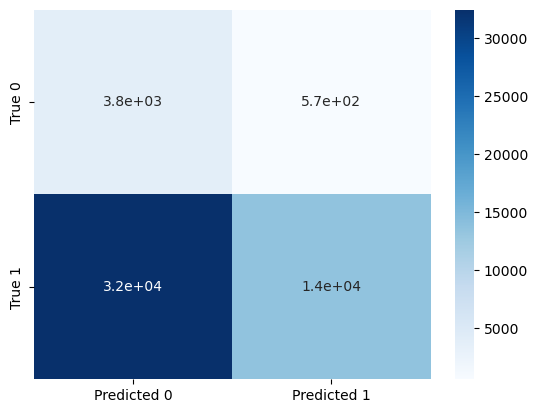

In [60]:
# Confusion matrix 
y_pred = (rf_pred_probas > thresh)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
cm.index = ['True 0', 'True 1']
cm.columns = ['Predicted 0', 'Predicted 1']
print("Threshold : ", thresh)
sns.heatmap(cm, annot=True, cmap="Blues")

### beta = 0.01

In [61]:
selected_beta = .01
thresh = scores_df[selected_beta].idxmax()
thresh

0.8383838383838385

Threshold :  0.8383838383838385


<Axes: >

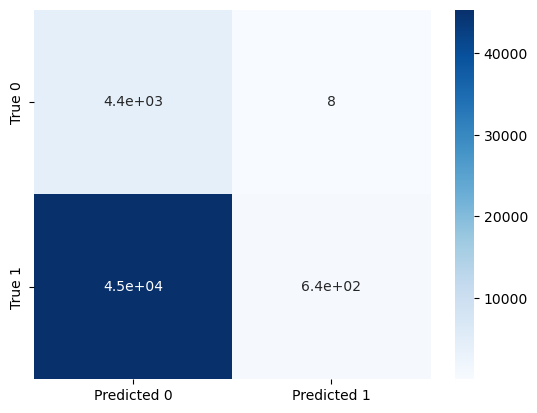

In [62]:
# Confusion matrix 
y_pred = (rf_pred_probas > thresh)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
cm.index = ['True 0', 'True 1']
cm.columns = ['Predicted 0', 'Predicted 1']
print("Threshold : ", thresh)
sns.heatmap(cm, annot=True, cmap="Blues")

### beta = 0.1

In [63]:
selected_beta = .1
thresh = scores_df[selected_beta].idxmax()
thresh

0.5757575757575758

Threshold :  0.5757575757575758


<Axes: >

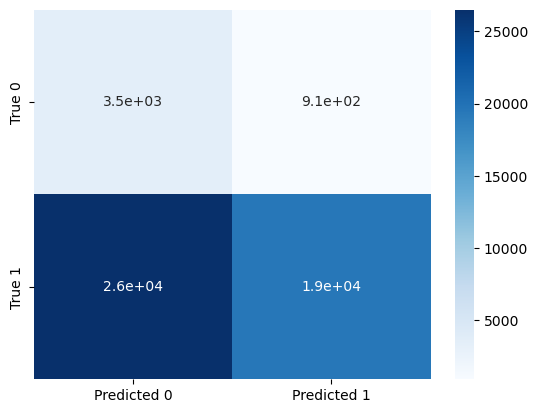

In [64]:
# Confusion matrix
y_pred = (rf_pred_probas > thresh)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
cm.index = ['True 0', 'True 1']
cm.columns = ['Predicted 0', 'Predicted 1']
print("Threshold : ", thresh)
sns.heatmap(cm, annot=True, cmap="Blues")

## Feature importance and explainer

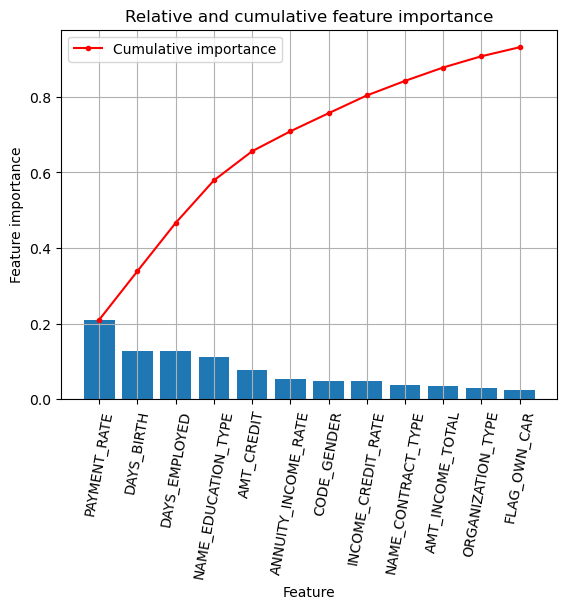

In [65]:
rf_best = RandFor.best_estimator_
# Looking at the feature importances in the best version of our model
importance_rf = pd.DataFrame.from_dict({
    'name': X.columns.to_list(),
    'feature_imp': rf_best.named_steps['classification'].feature_importances_
})
importance_rf = importance_rf.sort_values(by=['feature_imp'], ascending=False)
cumul_importance = np.cumsum(importance_rf['feature_imp'].head(12))
# Bar plot of relative and cumulative feature importances
plt.bar(importance_rf['name'].head(12), importance_rf['feature_imp'].head(12))
plt.plot(importance_rf['name'].head(12), cumul_importance, marker='.', c='r', label='Cumulative importance')
plt.xlabel('Feature')
plt.ylabel('Feature importance')
plt.xticks(ticks=np.linspace(0, 11, 12), labels=importance_rf['name'].head(12), rotation=80)
plt.title('Relative and cumulative feature importance')
plt.legend()
plt.grid()
plt.show()

In [66]:
def local_feat_imp(idx, X_train, X_test, y_test, categorical_features_idxs, categorical_names_dict, model, threshold):
    """Computes the local feature importances with LIME for a given individual in the dataset
    X_train : training dataset
    X_test, y_test : test dataset
    idx : index of the individual to be evaluated
    categorical_features_idxs : list of the indices of the categorical features in the dataset
    categorical_names_dict : map of the categorical features labels
    """
    # Generating the general explainer based on the features
    explainer = lime_tabular.LimeTabularExplainer(
        X_train.values,
        mode='classification',
        feature_names=X_train.columns.to_list(),
        categorical_features=categorical_features_idxs,
        categorical_names=categorical_names_dict,
        class_names=[0, 1]
    )
    # Predicting the result for the given individual
    pred_proba = model.predict_proba(X_test.loc[idx].values.reshape(1,-1))[0][1]
    pred = 1 if pred_proba > threshold else 0
    print("Prediction : ", pred)
    print("Actual :     ", y_test[idx])
    # Getting the explainer for this particular individual
    exp = explainer.explain_instance(
        X_test.loc[idx],
        model.predict_proba,
        num_features=6
    )
    exp.show_in_notebook()
    return explainer, exp

C:\Users\Paul\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Paul\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Prediction :  0
Actual :      1


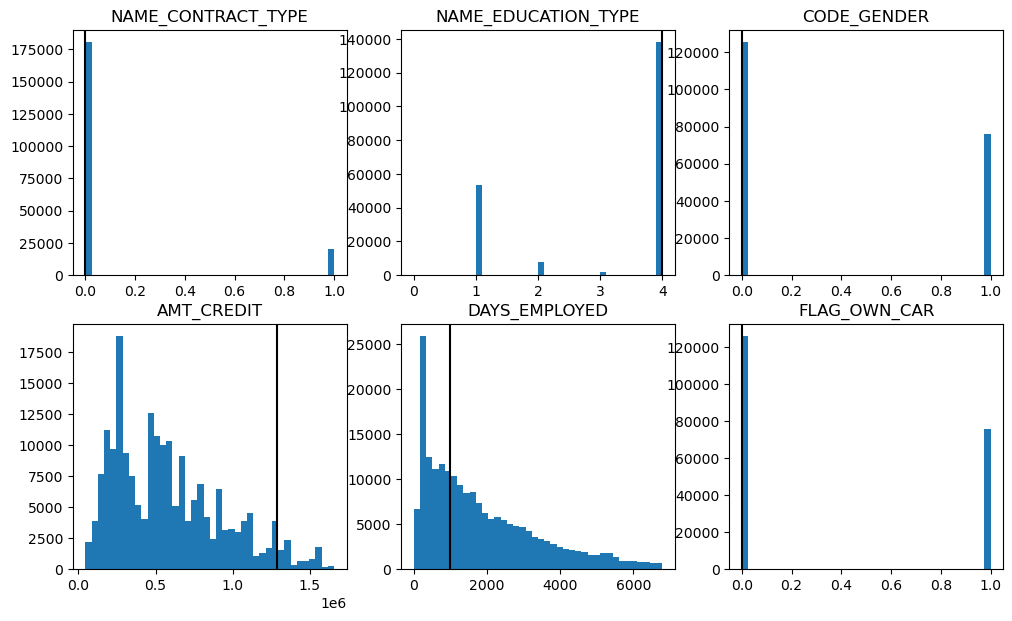

In [67]:
idx = random.choice(X_test.index)
# Example of explainer for a random individual in the dataset
exp, expl = local_feat_imp(idx, X_train, X_test, y_test, cat_features_ind, classes_names_dict, RandFor, thresh)
exp_details = expl.as_map()[1]
# Getting distributions for the features pointed by the explainer
j=1
fig = plt.figure(figsize=(12, 7))
for i in range(len(exp_details)):
    if X_test[X_test.columns[exp_details[i][0]]].dtype != 'category':
        ax = fig.add_subplot(2, 3, j)
        h = ax.hist(X_train[X_train.columns[exp_details[i][0]]], bins=40)
        plt.axvline(X_test.loc[idx, X_test.columns[exp_details[i][0]]], c='k')
        ax.set_title(X_train.columns[exp_details[i][0]])
        j += 1
plt.show()

# Re-training the model and preparing for the API

In [68]:
df = pd.read_csv(PATH+'cleaned_data.csv', index_col=0)
X = df.drop('TARGET', axis=1)
y = df['TARGET']
X, classes_names_dict, transformers_dict = label_enc(X, cat_features_ind)
# New train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

C:\Users\Paul\AppData\Local\Temp\ipykernel_10964\1457122039.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, [feature]] = le.transform(df.iloc[:, [feature]].values.ravel())
C:\Users\Paul\AppData\Local\Temp\ipykernel_10964\1457122039.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, [feature]] = le.transform(df.iloc[:, [feature]].values.ravel())
C:\Users\Paul\AppData\Local\Temp\ipykernel_10964\1457122039.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace 

In [69]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

In [70]:
# Setting custom metric
beta = .1
scoring_fn = fbeta_score
custom_scoring_func = make_scorer(scoring_fn, beta=beta, greater_is_better=True)
# Setting the hyperparameters found above
rf_final = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=2,
    max_features='sqrt',
    min_samples_leaf=5,
    random_state=42
)
# Fitting final model
rf_final.fit(X_res, y_res)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=200,
                       random_state=42)

In [71]:
idx = random.choice(X_test.index)
# Train local explainer
explainer = lime_tabular.LimeTabularExplainer(
    X_res.values,
    mode='classification',
    feature_names=X_train.columns.to_list(),
    categorical_features=cat_features_ind,
    categorical_names=classes_names_dict,
    class_names=[0, 1]
)
# Getting predictions
pred = 1 if rf_final.predict_proba(X_test.loc[idx].values.reshape(1, -1))[0][0] > thresh else 0
print("Prediction : ", pred)
print("Actual :     ", y_test[idx])
#Explain instance on random sample
exp = explainer.explain_instance(
    X_test.loc[idx],
    rf_final.predict_proba,
    num_features=6
)
exp.show_in_notebook()

C:\Users\Paul\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Paul\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Prediction :  1
Actual :      1


In [72]:
# Saving transformers, model, explainer and features into pickles
pickle.dump(transformers_dict, open('Pickles/transformers.pkl', 'wb'))
pickle.dump(rf_best, open('Pickles/randfor.pkl', 'wb'))
pickle.dump(explainer, open('Pickles/explainer.pkl', 'wb'))
pickle.dump(features_dict, open('Pickles/features.pkl', 'wb'))

In [73]:
# Saving distributions as a pickle
distributions_dict = {
    'PAYMENT_RATE': df['PAYMENT_RATE'].tolist(),
    'DAYS_EMPLOYED': df['DAYS_EMPLOYED'].tolist(),
    'DAYS_BIRTH': df['DAYS_BIRTH'].tolist(),
    'AMT_CREDIT': df['AMT_CREDIT'].to_list(),
    'AMT_INCOME_TOTAL': df['AMT_INCOME_TOTAL'].tolist(),
    'INCOME_CREDIT_RATE': df['INCOME_CREDIT_RATE'].tolist(),
    'ANNUITY_INCOME_RATE': df['ANNUITY_INCOME_RATE'].tolist()
}
pickle.dump(distributions_dict, open('Pickles/distributions.pkl', 'wb'))

# Data drift analysis

In [75]:
ref = pd.concat(X_train, y_train)
cur = pd.concat(X_test, y_test)
reference = ref.copy()
current = cur.copy()
current = current.drop(columns='SK_ID_CURR')

C:\Users\Paul\AppData\Local\Temp\ipykernel_10964\3459336361.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  ref = pd.concat(X_train, y_train)


TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [ ]:
start_time = time.time()

report = Report(metrics=[DataDriftPreset()])
report.run(reference_data=reference, current_data=current)

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time

In [ ]:
report.save_html("Evidently_report_full.html")